# Comparison of 10X Nucleus vs. Segger Monocyte Capture

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from requirements import *
from segger.data.parquet._utils import (
    read_parquet_region,
    filter_transcripts,
    load_settings,
)
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import *
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.utils import lighten_color, get_color_palette
import celltypist as ct
import ast

In [3]:
dataset = 'xenium_colon'

## Aggregate Cell Type Markers from Literature

Because Xenium is limited in the number of genes in a given panel, cell type signatures from literature are sparse and often missing genes critical to the specificity of a signature. Below is a manually curated list of marker sets from three different sources, aggregated across cell types and filtered for meaningless signatures (i.e. those missing genes critical to a gene sets specificity).

In [204]:
name = '10x_nucleus'
ad = sc.read_h5ad(data_dir / dataset / f'h5ads/{name}_raw.h5ad')

In [205]:
# Read in 10X marker annotations
filepath = data_dir / dataset / 'supplementary/xenium_hcolon_v1_markers.csv'
df = pd.read_csv(filepath, usecols=[1, 2, 3])

drop_types = ['colon cancer']
df = df[~df.label.isin(drop_types)]

df['source'] = '10X Genomics'
df_10xg = df

In [206]:
# Read in markers from Kong et al, 2023
df = pd.read_excel(
    data_dir / dataset / 'supplementary/kong_et_al_markers.xlsx',
    usecols=[0, 1, 2],
)
# Split markers column into rows
df['Markers'] = df['Markers'].apply(ast.literal_eval)
df = df.explode('Markers')

# Filter out genes missing from panel
df = df[df['Markers'].isin(ad.var.index)]

# Rename compartment labels
df['compartment'] = df['Compartment'].str.lower()
df.loc[df['Cell subset name'].eq('L cells '), 'compartment'] = 'epithelial'

df['source'] = 'Kong et al, 2023'
df = df.rename({'Markers': 'gene', 'Cell subset name': 'label'}, axis=1)
df_kong = df

In [207]:
# Read in markers from Elmentaite et al, 2021
df = pd.read_excel(
    data_dir / dataset / 'supplementary/elmentaite_et_al_markers.xlsx',
    usecols=[1, 2, 10, 13],
)

# Filter out genes missing in panel and keep only most diffex genes
mask = df['genes'].isin(ad.var.index) & df['logfoldchanges'].gt(2)
df = df[mask]

# Remap compartment labels
df['compartment'] = df['lineage '].map({
    'Epithelial': 'epithelial',
    'T_NK_cells': 'immune',
    'Mesenchymal': 'stromal',
    'B_plasma_redbloodcells': 'immune',
    'myeloid': 'immune',
    'endothelial': 'stromal',
    'neural': 'stromal',
})
df.loc[df['cluster'].eq('FDC'), 'compartment'] = 'immune'

df['source'] = 'Elmentaite et al, 2021'
df = df.rename(dict(genes='gene', cluster='label'), axis=1)
df_elmentaite = df

In [208]:
rows = [
    ('PECAM1', 'Endothelial Cell', 'stromal'),
    ('PKHD1L1', 'Endothelial Cell', 'stromal'),
    ('PROX1', 'Endothelial Cell', 'stromal'),
    ('CD3E', 'Cycling Immune Cell', 'immune'),
    ('CD79A', 'Cycling Immune Cell', 'immune'),
    ('CD24', 'Transit Amplifying Cell', 'epithelial'),
    ('TUBA1A', 'Glial Cell', 'stromal'),
    ('DPYSL3', 'Glial Cell', 'stromal'),
    ('CLU', 'Glial Cell', 'stromal'),
    ('PRPH', 'Glial Cell', 'stromal'),
    ('TAGLN', 'Smooth Muscle Cell', 'stromal'),
    ('ACTA2', 'Smooth Muscle Cell', 'stromal'),
    ('COL1A1', 'Smooth Muscle Cell', 'stromal'),
    ('THBS1', 'Smooth Muscle Cell', 'stromal'),
    ('GREM1', 'Smooth Muscle Cell', 'stromal'),
    ('GREM2', 'Smooth Muscle Cell', 'stromal'),
    ('IL1B', 'Neutrophil', 'immune'),
    ('CXCR1', 'Neutrophil', 'immune'),
    ('CXCR2', 'Neutrophil', 'immune'),
    ('CXCL1', 'Neutrophil', 'immune'),
]
df = pd.DataFrame(rows, columns=['gene', 'label', 'compartment'])
df['group'] = df['label']
df['source'] = 'Custom'
df_custom = df

In [209]:
# Join all annotations
df = pd.concat([df_10xg, df_kong, df_elmentaite, df_custom], join='inner')
df['label'] = df['label'].str.strip()

In [210]:
# Aggregate labels from literature
label_groupings = {
    'Stem Cell': [
        'stem cell, 10X Genomics',
        'Stem cells, Elmentaite et al, 2021',
    ],
    'Transit Amplifying Cell': [
        'transit amplifying cell of colon, 10X Genomics',
        'Epithelial Cycling cells, Kong et al, 2023',
        'Transit Amplifying Cell, Custom',
    ],
    'OLFM4+ Stem Cell': [
        'Stem cells OLFM4+, Kong et al, 2023',
        'Stem cells OLFM4+ PCNA+, Kong et al, 2023'
    ],
    'Goblet Cell': [
        'colon goblet cell, 10X Genomics',
        'Goblet cells MUC2+ TFF1-, Kong et al, 2023',
        'Goblet cells MUC2+ TFF1+, Kong et al, 2023',
        'Goblet cells SPINK4+, Kong et al, 2023',
        'Goblet cell, Elmentaite et al, 2021'
    ],
    'BEST4+ Epithelial Cell': [
       'BEST4+ epithelial cell, 10X Genomics',
       'Enterocytes BEST4+, Kong et al, 2023',
       'BEST4+ epithelial, Elmentaite et al, 2021',
    ],
    'Paneth Cell': [
        'paneth cell of colon, 10X Genomics',
    ],
    'Absorptive Precursor Cell': [
        'absorptive cell, 10X Genomics',
        'Enterocytes CA1+ CA2+ CA4-, Kong et al, 2023',
    ],
    'Enterocyte': [
        'Enterocytes TMIGD1+ MEP1A+, Kong et al, 2023',
        'Enterocytes TMIGD1+ MEP1A+ GSTA1+, Kong et al, 2023',
        'Colonocyte, Elmentaite et al, 2021',
    ],
    'Macrophage': [
        'colon macrophage, 10X Genomics',
        'Macrophages, Kong et al, 2023',
    ],
    'LYVE1+ Macrophage': [
        'macrophage, 10X Genomics',
        'Macrophages LYVE1+, Kong et al, 2023',
        'LYVE1+ Macrophage, Elmentaite et al, 2021',
    ],
    'Endothelial Cell': [
        'Endothelial cells CA4+ CD36+, Kong et al, 2023',
        'Endothelial cells CD36+, Kong et al, 2023',
        'Endothelial cells DARC+, Kong et al, 2023',
        'LEC6 (ADAMTS4+), Elmentaite et al, 2021',
        'LEC2 (MADCAM1+), Elmentaite et al, 2021',
        'LEC5 (CLDN11+), Elmentaite et al, 2021',
        'Endothelial Cell, Custom',
    ],
    'Stromal 1': [
        'Fibroblasts ADAMDEC1+, Kong et al, 2023',
        'Stromal 1 (ADAMDEC1+), Elmentaite et al, 2021',
        'Stromal 1 (CCL11+), Elmentaite et al, 2021',
    ],
    'Stromal 2': [
        'Fibroblasts NPY+ SLITRK6+, Kong et al, 2023',
        'Stromal 2 (CH25H+), Elmentaite et al, 2021',
        'Stromal 2 (NPY+), Elmentaite et al, 2021',
    ],
    'Stromal 3': [
        'Stromal 3 (C7+), Elmentaite et al, 2021',
        'Fibroblasts SFRP2+ SLPI+, Kong et al, 2023',
        'Transitional Stromal 3 (C3+), Elmentaite et al, 2021',
    ],
    'Pericyte': [
        'Pericytes HIGD1B+ STEAP4+, Kong et al, 2023',
        'Pericytes RERGL+ NTRK2+, Kong et al, 2023',
        'Contractile pericyte (PLN+), Elmentaite et al, 2021',
        'Immature pericyte, Elmentaite et al, 2021',
    ],
    'Myofibroblast': [
        'myofibroblast, Elmentaite et al, 2021',
    ],
    'Glial Cell': [
        'Glial cells, Kong et al, 2023',
        'Glial Cell, Custom',
    ],
    'Treg': [
        'regulatory T cell, 10X Genomics',
        'Tregs, Kong et al, 2023',
        'Treg, Elmentaite et al, 2021',
    ],
    'CD4+ T Cell': [
        'CD4-positive, alpha-beta T cell, 10X Genomics',
        'T cells CD4+ FOSB+, Kong et al, 2023',
        'T cells Naive CD4+, Kong et al, 2023',
        'T-helper 1 cell, 10X Genomics',
        'T-helper 17 cell, 10X Genomics',
    ],
    'CD8+ T Cell': [
        'CD8-positive, alpha-beta T cell, 10X Genomics',
        'T cells CD8+, Kong et al, 2023',
        'T cells CD8+ KLRG1+, Kong et al, 2023',
    ],
    'B Cell': [
        'follicular B cell, 10X Genomics',
        'memory B cell, 10X Genomics',
        'B cells, Kong et al, 2023',
        'Pre-B, Elmentaite et al, 2021',
    ],
    'Cycling Immune Cell': [
        'Immune Cycling cells, Kong et al, 2023',
        'Cycling B cell, Elmentaite et al, 2021',
        'Cycling Immune Cell, Custom',
    ],
    'Plasma Cell': [
        'IgA plasma cell, 10X Genomics',
        'Plasma cells, Kong et al, 2023',
    ],
    'Monocyte': [
        'monocyte, 10X Genomics',
        'Monocytes S100A8+ S100A9+, Kong et al, 2023',
    ],
    'cDC': [
        'conventional dendritic cell, 10X Genomics',
        'DC1, Kong et al, 2023',
        'cDC1, Elmentaite et al, 2021',
    ],
    'EC Cell': [
        'Enterochromaffin cells, Kong et al, 2023',
        'EC cells (NPW+), Elmentaite et al, 2021',
    ],
    'L Cell': [
        'L cells (PYY+), Elmentaite et al, 2021',
        'L cells, Kong et al, 2023',
    ],
    'Tuft Cell': [
        'tuft cell, 10X Genomics',
        'Tuft cells, Kong et al, 2023',
        'Tuft, Elmentaite et al, 2021',
    ],
    'Mast Cell': [
        'mast cell, 10X Genomics',
        'Mast cells, Kong et al, 2023',
        'Mast cell, Elmentaite et al, 2021',
    ],
    'ICC': [
        'ICC, Elmentaite et al, 2021',
    ],
    'Smooth Muscle Cell': [
        'Smooth Muscle Cell, Custom',
    ],
    'FDC': [
        'FDC, Elmentaite et al, 2021',
    ],
    'Neutrophil': [
        'Neutrophil, Custom',
    ],
}

label_groupings = {v: k for k, vals in label_groupings.items() for v in vals}
df['group'] = (df['label'] + ', ' + df['source']).map(label_groupings)

In [211]:
# Simplify cell type labels for plotting
l1_groupings = {
    'Stromal 3': 'Stromal 2',
    'Monocyte': 'Monocyte',
    'LYVE1+ Macrophage': 'Macrophage',
    'Cycling Immune Cell': 'T Cell',
    'CD4+ T Cell': 'T Cell',
    'Endothelial Cell': 'Endothelial',
    'Pericyte': 'Pericyte',
    'Glial Cell': 'Glia',
    'Mast Cell': 'Mast',
    'Smooth Muscle Cell': 'Smooth Muscle',
    'ICC': 'ICC',
    'Stromal 1': 'Stromal 1',
    'Macrophage': 'Macrophage',
    'B Cell': 'B Cell',
    'Stromal 2': 'Stromal 1',
    'Tuft Cell': 'Tuft',
    'Myofibroblast': 'Stromal 1',
    'Plasma Cell': 'Plasma',
    'BEST4+ Epithelial Cell': 'BEST4+ Epi.',
    'CD8+ T Cell': 'T Cell',
    'Transit Amplifying Cell': 'TA/Precursor',
    'Stem Cell': 'ISC', 
    'Goblet Cell': 'Goblet',
    'L Cell': 'Enteroendocrine',
    'EC Cell': 'Enteroendocrine',
    'OLFM4+ Stem Cell': 'ISC',
    'Absorptive Precursor Cell': 'TA/Precursor',
    'Enterocyte': 'Enterocyte',
    'Paneth Cell': 'Paneth',
    'cDC': 'DC',
    'FDC': 'DC',
    'Treg': 'T Cell',
    'Neutrophil': 'Neutrophil',
}
df['level_1'] = df['group'].map(l1_groupings)

In [212]:
# Simplify cell type labels for plotting
l2_groupings = {
    'Stromal 3': 'Fibroblast and Stromal',
    'Monocyte': 'Myeloid',
    'LYVE1+ Macrophage': 'Myeloid',
    'Cycling Immune Cell': 'Lymphoid',
    'CD4+ T Cell': 'Lymphoid',
    'Endothelial Cell': 'Endothelial',
    'Pericyte': 'Smooth Muscle and Pericyte',
    'Glial Cell': 'Neural',
    'Mast Cell': 'Myeloid',
    'Smooth Muscle Cell': 'Smooth Muscle and Pericyte',
    'ICC': 'Smooth Muscle and Pericyte',
    'Stromal 1': 'Fibroblast and Stromal',
    'Macrophage': 'Myeloid',
    'B Cell': 'Lymphoid',
    'Stromal 2': 'Fibroblast and Stromal',
    'Tuft Cell': 'Epithelial',
    'Myofibroblast': 'Fibroblast and Stromal',
    'Plasma Cell': 'Lymphoid',
    'BEST4+ Epithelial Cell': 'Epithelial',
    'CD8+ T Cell': 'Lymphoid',
    'Transit Amplifying Cell': 'Epithelial',
    'Stem Cell': 'Epithelial', 
    'Goblet Cell': 'Epithelial',
    'L Cell': 'Epithelial',
    'EC Cell': 'Epithelial',
    'OLFM4+ Stem Cell': 'Epithelial',
    'Absorptive Precursor Cell': 'Epithelial',
    'Enterocyte': 'Epithelial',
    'Paneth Cell': 'Epithelial',
    'cDC': 'Myeloid',
    'FDC': 'Myeloid',
    'Treg': 'Lymphoid',
    'Neutrophil': 'Myeloid',
}
df['level_2'] = df['group'].map(l2_groupings)

In [213]:
# Save to file
df.to_csv(data_dir / dataset / 'supplementary/cell_type_markers.csv')

## Create and Annotate AnnData from Transcripts

### Transcripts to AnnData

In [4]:
# Read in all transcripts
transcripts_filepath = data_dir / dataset / 'labeled_transcripts.parquet'
transcripts = pd.read_parquet(transcripts_filepath)

# Filter control probes and low QV probes
xe_settings = load_settings('xenium')
transcripts = filter_transcripts(
    transcripts,
    label=xe_settings.transcripts.label,
    filter_substrings=xe_settings.transcripts.filter_substrings,
    min_qv=25,
)

In [7]:
# Subset Segger data to high-confidence transcripts
for name, seg_col, mask in [
    #('10x_cell', 'cell_id', np.full(transcripts.shape[0], True)),
    #('10x_nucleus', 'cell_id', transcripts['overlaps_nucleus'].eq(1)),
    #('segger', 'segger_cell_id_k=20', transcripts['score_k=20'].gt(0.5)),
    #('segger_embedding', 'segger_cell_id_cxg_k=20', transcripts['score_cxg_k=20'].gt(0.5))
]:

    # Transcripts to anndata
    ad = anndata_from_transcripts(
        transcripts[mask],
        cell_label=seg_col,
        gene_label='feature_name',
        coordinate_labels=['x_location', 'y_location'],
    )
    # Add raw counts before filtering
    ad.uns['raw_counts'] = dict(
        index=ad.obs.index.tolist(),
        count=ad.raw.X.A.sum(1),
    )
    ad.write_h5ad(data_dir / dataset / f'h5ads/{name}_raw.h5ad')
    
    # Preprocess
    preprocess_rapids(
        ad,
        filter_min_counts=1,
        pca_total_var=0.95,
        umap_min_dist=0.2,
        umap_n_epochs=1000,
        pca_layer='norm',
        knn_neighbors=20,
        phenograph_resolution=4,
        umap_kwargs=dict(local_connectivity=2, init_pos='random'),
    )
    
    # Map 10X IDs across anndatas
    if name in ['10x_nucleus', '10x_cell', '10x_nucleus_lo_thresh']:
        ad.obs['10x_id'] = ad.obs.index
    else:
        counts = transcripts.value_counts([seg_col, 'cell_id'])
        nuc_map = counts.groupby(seg_col).idxmax().str[1]
        ad.obs['10x_id'] = ad.obs.index.astype(float).map(nuc_map)
    
    ad.write_h5ad(data_dir / dataset / f'h5ads/{name}_processed.h5ad')

Done: 100%|██████████| 6/6 [01:06<00:00, 11.09s/it]         


### Build Celltypist Model on 10X Nucleus AnnData

In [79]:
# Read in AnnData
name = '10x_nucleus'
ad_nuc = sc.read_h5ad(data_dir / dataset / f'h5ads/{name}_processed.h5ad')

# Read in cell type markers from literature
filepath = data_dir / dataset / 'supplementary/cell_type_markers.csv'
markers = pd.read_csv(filepath)

# Z-score data before gene set scoring
X = ad_nuc.layers['lognorm'].todense().A
ad_nuc.layers['z-score'] = sp.stats.zscore(X, axis=0)

# Ignore performance warnings from calling insert
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Score all genes
ad_nuc.X = ad_nuc.layers['z-score']
col = 'group'
for name, group in tqdm(markers.groupby(col)):
    sc.tl.score_genes(
        adata=ad_nuc,
        gene_list=group['gene'].unique(),
        score_name=name,
        use_raw=False,
    )

100%|██████████| 33/33 [00:19<00:00,  1.74it/s]


In [80]:
# Join into single .obsm entry
ad_nuc.obsm['X_cell_type'] = ad_nuc.obs[markers[col].dropna().unique()]

# Max cell type by cluster
gb = 'phenograph_cluster'
fn = 'mean'
ct_agg = sc.get.aggregate(ad_nuc, gb, fn, obsm='X_cell_type').to_df(layer=fn)
ct_agg.index = ct_agg.index.astype(int)
ct_map = ct_agg.idxmax(1)

# Compartment by cluster
cp_map = markers.dropna().set_index(col)['compartment']
cp_map = cp_map[~cp_map.index.duplicated()]

# Map cluster/compartment assignments to dataset
ad_nuc.obs['prelim_cell_type'] = ad_nuc.obs[gb].map(ct_map)

In [81]:
# Build Celltypist model on nuclear AnnData
ad_nuc.layers['raw'] = ad_nuc.raw.X.copy()
ct_model = build_celltypist_model(
    ad_nuc,
    celltype_col='prelim_cell_type',
    raw_layer='raw',
    target_sum=100,
    sample_size=1000,
)
ct_model.write(data_dir / dataset / 'celltypist/colon_celltypist_model.pkl')

### Cell Type All AnnDatas

In [214]:
# Neutrophil IDs
filepath = data_dir / dataset / f'h5ads/segger_embedding_processed.h5ad'
ad = sc.read_h5ad(filepath)
is_neutrophil = ad.obs['phenograph_cluster'].eq(62)
neutrophil_ids = ad.obs.loc[is_neutrophil, '10x_id'].values

In [215]:
# Annotate using celltypist model
filepath = data_dir / dataset / 'celltypist/colon_celltypist_model.pkl'
ct_model = ct.Model.load(str(filepath))

# Read in cell type markers from literature
filepath = data_dir / dataset / 'supplementary/cell_type_markers.csv'
markers = pd.read_csv(filepath)

for name in ['10x_nucleus', '10x_cell', 'segger', 'segger_embedding']:
    
    # Label anndata
    filepath = data_dir / dataset / f'h5ads/{name}_processed.h5ad'
    ad = sc.read_h5ad(filepath)
    annotate_cell_types(ad, ct_model, target_sum=100)
    ad.obs['cell_type'] = ad.obs['celltypist_label'].astype(str)
    mask = ad.obs['10x_id'].isin(neutrophil_ids)
    ad.obs.loc[mask, 'cell_type'] = 'Neutrophil'

    # Map to coarse labels for plotting
    for l in [1, 2]:
        counts = markers.groupby('group')[f'level_{l}'].value_counts()
        ct_map = counts.unstack().idxmax(1)  # coarse labels
        ad.obs[f'cell_type_level_{l}'] = ad.obs['cell_type'].map(ct_map)
    
    ad.write_h5ad(filepath)

... storing 'cell_type' as categorical
... storing 'cell_type_level_1' as categorical
... storing 'cell_type_level_2' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_level_1' as categorical
... storing 'cell_type_level_2' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_level_1' as categorical
... storing 'cell_type_level_2' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_level_1' as categorical
... storing 'cell_type_level_2' as categorical


# Other

In [599]:
name = '10x_nucleus'
filepath = data_dir / dataset / f'h5ads/{name}_processed.h5ad'
ad = sc.read_h5ad(filepath)
palette = get_color_palette(ad, 'cell_type_coarse', 'norm', n=0.25)

In [600]:
name = 'segger'
filepath = data_dir / dataset / f'h5ads/{name}_processed.h5ad'
ad = sc.read_h5ad(filepath)
palette = get_color_palette(ad, 'cell_type_coarse', 'norm', n=0.25)

In [590]:
palette = named_colors['Cell Type']

In [594]:
palette['Paneth'] = palette['T Cell']

Text(0.5, 1.0, '')

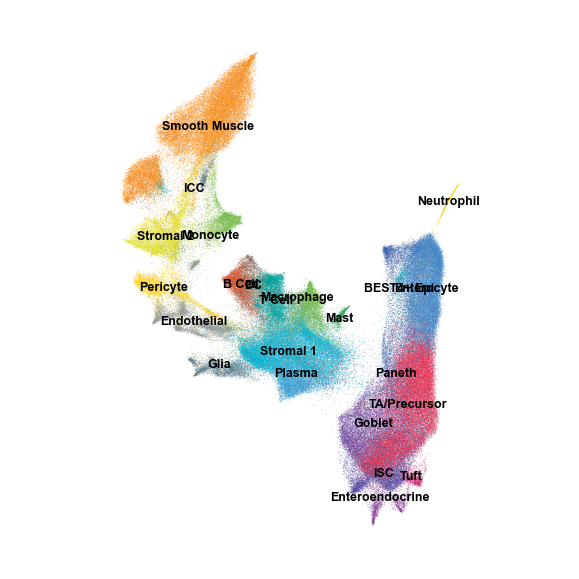

In [621]:
fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25))
styles = dict(
    s=0.067,
    palette=named_colors['Cell Type'],
    legend_loc='on data',
    legend_fontsize=3,
)
_ = plot_embedding(ad, 'cell_type_coarse', ax=ax, **styles)
ax.set_title('')

In [670]:
name = '10x_cell'
filepath = data_dir / dataset / f'h5ads/{name}_processed.h5ad'
ad = sc.read_h5ad(filepath)

In [663]:
name = '10x_nucleus'
filepath = data_dir / dataset / f'h5ads/{name}_processed.h5ad'
ad.write_h5ad(filepath)

In [665]:
preprocess_rapids(
    ad,
    filter_min_counts=25,
    pca_total_var=0.95,
    umap_min_dist=0.2,
    umap_n_epochs=1000,
    pca_layer='norm',
    knn_neighbors=20,
    phenograph_resolution=4,
    #umap_kwargs=dict(local_connectivity=2, init_pos='random'),
)

Done: 100%|██████████| 6/6 [00:47<00:00,  7.89s/it]         


In [ ]:
ad = sc.read_h5ad(filepath)

TypeError: sg_utils.pl.plot_embedding.plot_embedding() got multiple values for keyword argument 'palette'

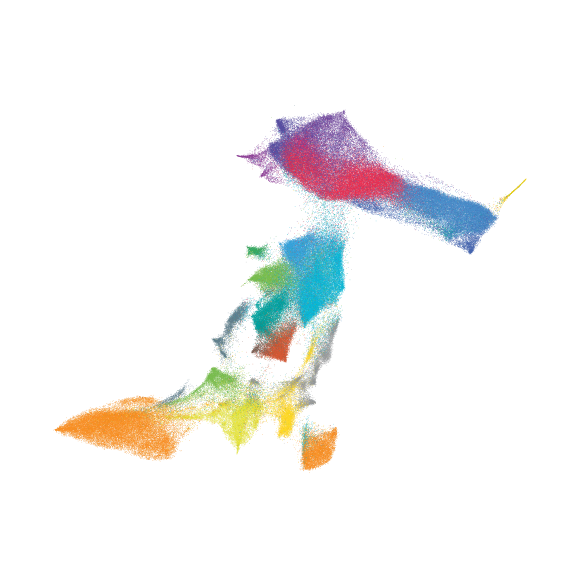

In [677]:
fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25))
styles = dict(
    palette=named_colors['Cell Type'],
    legend_loc='ondata',
    legend_fontsize=1.5,
)
_ = plot_embedding(ad, 'cell_type_coarse', ax=ax, s=0.067, **styles)
ax.set_title('')

styles.update(dict(palette=dict(Tuft='
_ = plot_embedding(
    ad[ad.obs['cell_type_coarse'].eq('Tuft')],
    'cell_type_coarse',
    s=0.5,
    ax=ax,
    **styles,
)
ax.set_title('')

Text(0.5, 1.0, '')

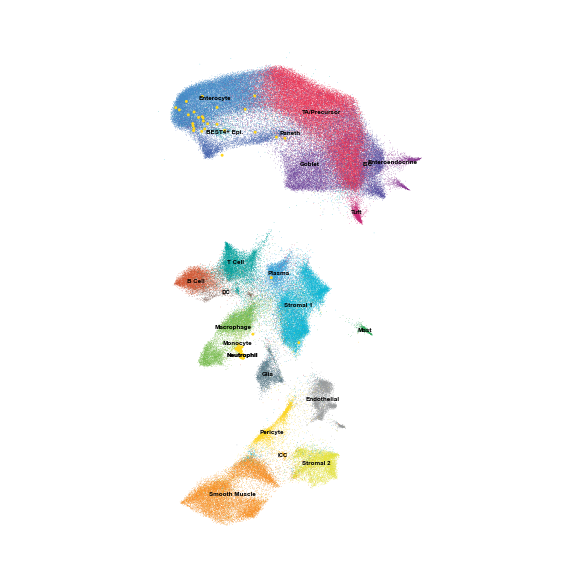

In [636]:
fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25))
styles = dict(
    palette=named_colors['Cell Type'],
    legend_loc='on data',
    legend_fontsize=1.5,
)
_ = plot_embedding(ad, 'cell_type_coarse', ax=ax, s=0.067, **styles)
_ = plot_embedding(
    ad[ad.obs['cell_type_coarse'].eq('Neutrophil')],
    'cell_type_coarse',
    s=2,
    ax=ax,
    **styles,
)
ax.set_title('')

In [408]:
# Read in AnnData
name = 'segger'
ad_seg.write_h5ad(data_dir / dataset / f'h5ads/{name}_processed.h5ad')

... storing 'cell_type_simple' as categorical


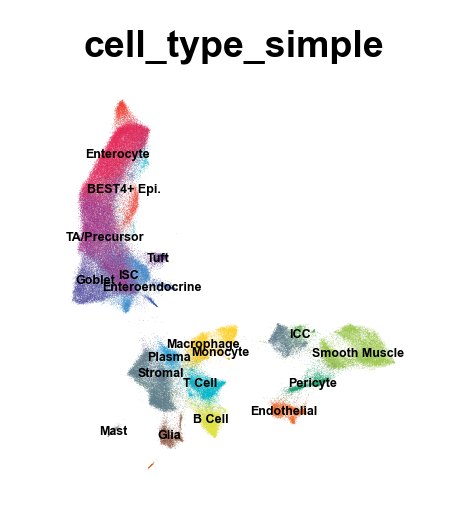

In [511]:
_ = plot_embedding(
    ad_nuc,
    ['cell_type_simple'],
    s=0.05,
    dim=2,
    sort_order=False,
    vmin=0,
    vmax='p99.9',
    layer='lognorm',
    legend_loc='on data',
    legend_fontsize=3,
    palette=cell_type_cmap,
)

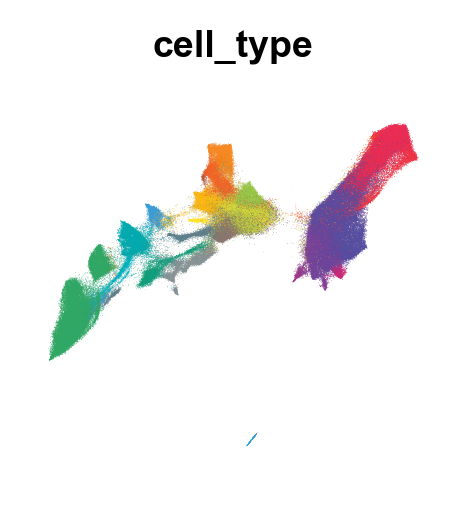

In [317]:
_ = plot_embedding(
    ad_seg,
    ['cell_type'],
    s=s,
    dim=2,
    sort_order=False,
    vmin=0,
    vmax='p99.9',
    layer='lognorm',
    legend_loc='ondata',
    legend_fontsize=3,
    palette=cell_type_cmap.to_dict(),
    basis='X_umap',
)

### Map Annotations to Segger Dataset

In [ ]:
# Read in AnnData
name = 'segger'
ad_seg = sc.read_h5ad(data_dir / dataset / f'h5ads/{name}_raw.h5ad')

In [232]:
# Preprocess
thresh = 25
preprocess_rapids(
    ad_seg,
    filter_min_counts=thresh,
    pca_total_var=0.95,
    umap_min_dist=0.15,
    umap_n_epochs=5000,
    pca_layer='norm',
    knn_neighbors=20,
    phenograph_resolution=4,
)

Done: 100%|██████████| 6/6 [01:13<00:00, 12.30s/it]         


In [233]:
# Get most frequent nucleus label for each segger cell label
seg_col = 'segger_cell_id_k=20'
counts = transcripts.value_counts([seg_col, 'nucleus_id'])
nuc_map = counts.groupby(seg_col).idxmax().str[1]
ad_seg.obs['nucleus_id'] = ad_seg.obs.index.astype(float).map(nuc_map)

In [234]:
# Map cell type labels to Segger dataset
ad_seg.obs['cell_type_nucleus'] = ad_seg.obs.nucleus_id.map(
    ad_nuc.obs['cell_type']
)

In [235]:
# Map labels on per-cluster level for unlabeled cells
gb = ad_seg.obs.groupby('phenograph_cluster')
labels = gb['cell_type_nucleus'].value_counts().unstack().idxmax(1)
ct_cluster = ad_seg.obs['phenograph_cluster'].map(labels)

ct_nuc = ad_seg.obs['cell_type_nucleus']
ad_seg.obs['cell_type'] = np.where(ct_nuc.isna(), ct_cluster, ct_nuc)

In [236]:
k = 100
nearest_neighbors(ad_seg, k, key_added='missing')
mask = ad_seg.obs['nucleus_id'].isin(ad.obs.index)
nn = 1 - (ad_seg.obsp['missing_connectivities'][:, mask].sum(1) / k)
ad_seg.obs['neighbor_missing_frac'] = nn

... storing 'nucleus_id' as categorical
... storing 'cell_type' as categorical


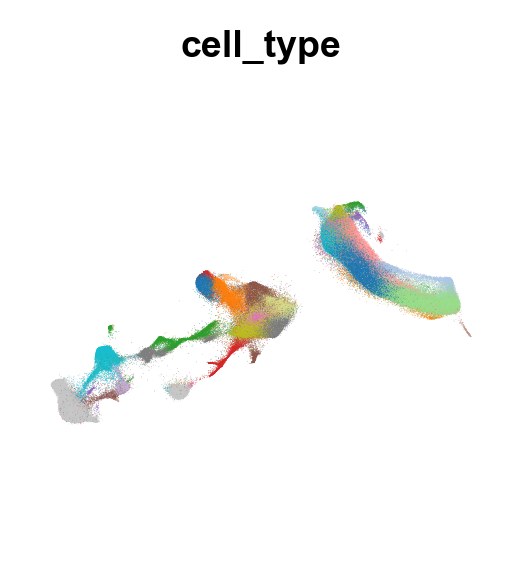

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = plot_embedding(
    ad_seg,
    ['cell_type'],
    s=0.1,
    ax=ax,
    sort_order=False,
    vmin=0,
    layer='z-score',
    legend_loc='on_data',
    legend_fontsize=3,
)

... storing 'cell_type' as categorical


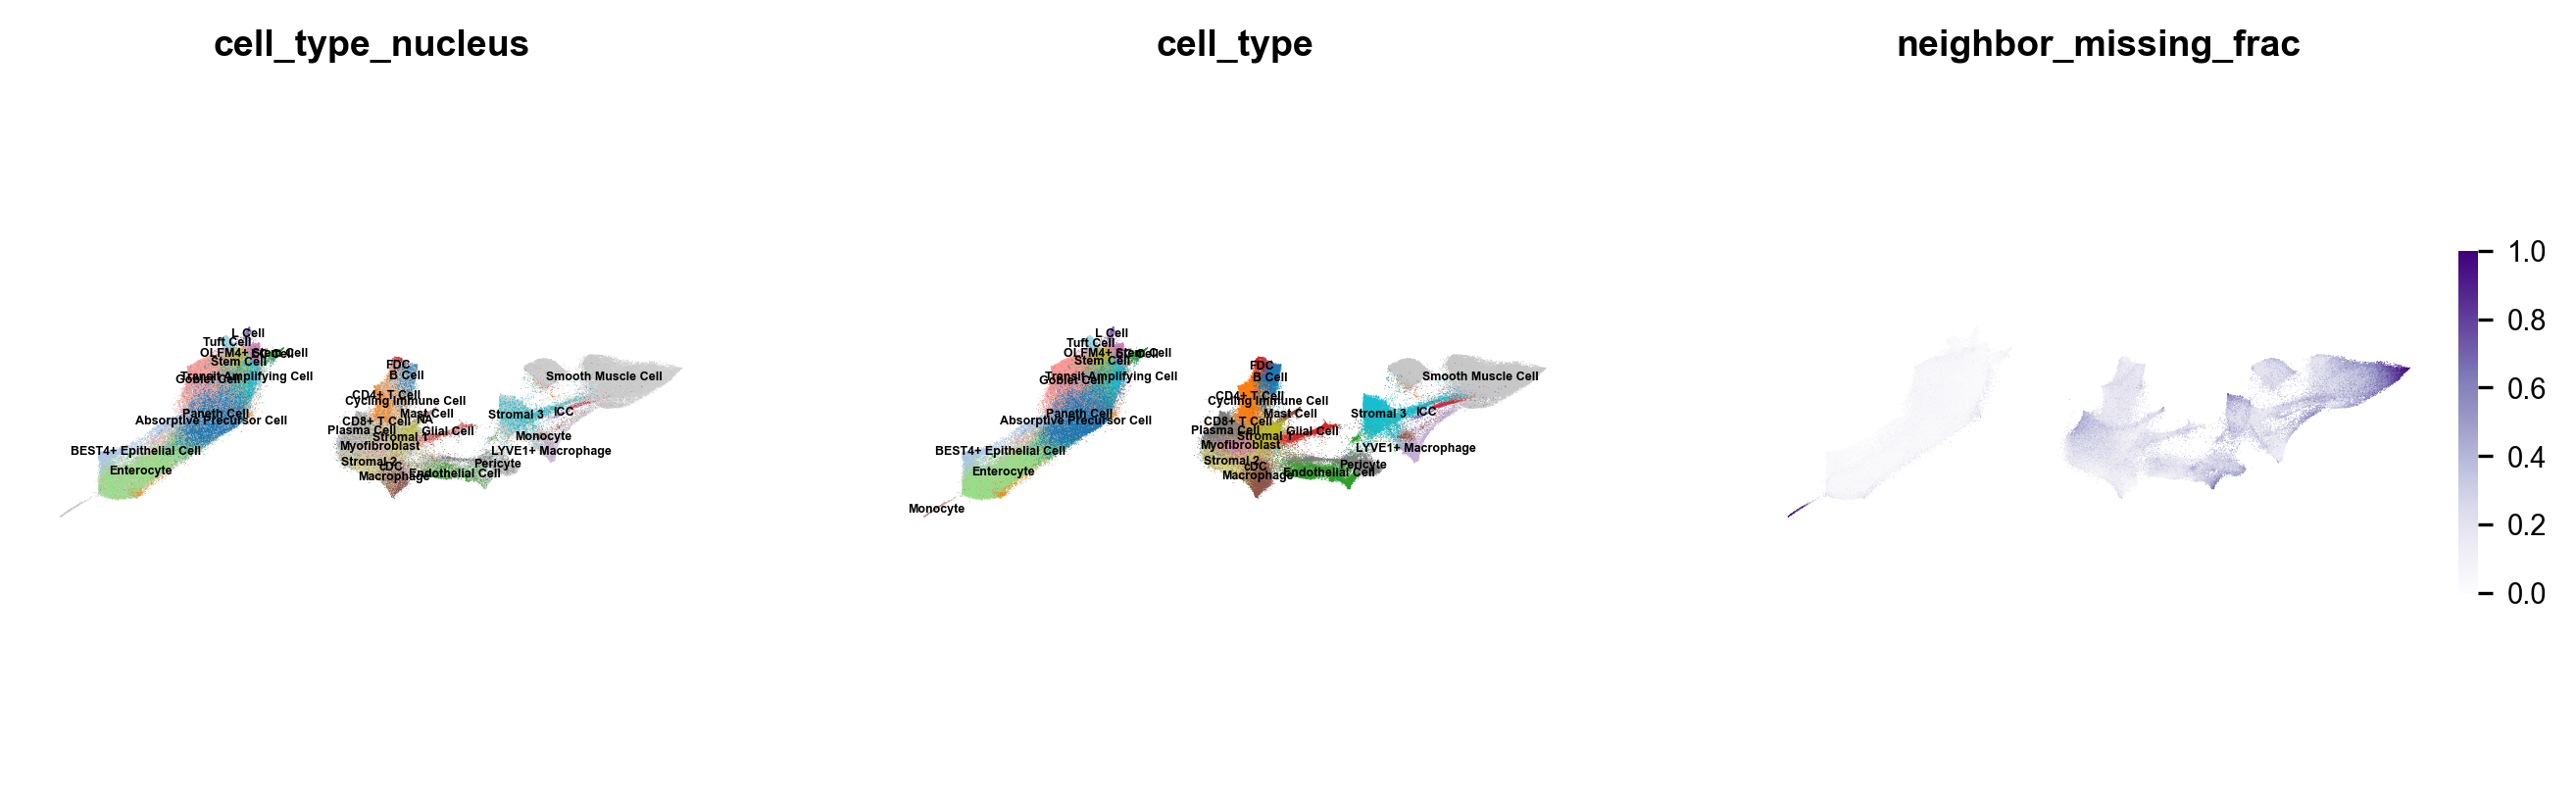

In [163]:
 _ = plot_embedding(
    ad_seg,
    ['cell_type_nucleus', 'cell_type', 'neighbor_missing_frac'],
    s=0.2,
    dim=3,
    sort_order=False,
    vmin=0,
    layer='z-score',
    legend_loc='on data',
    legend_fontsize=3,
    
    vmax=1,
     cmap='Purples',
)

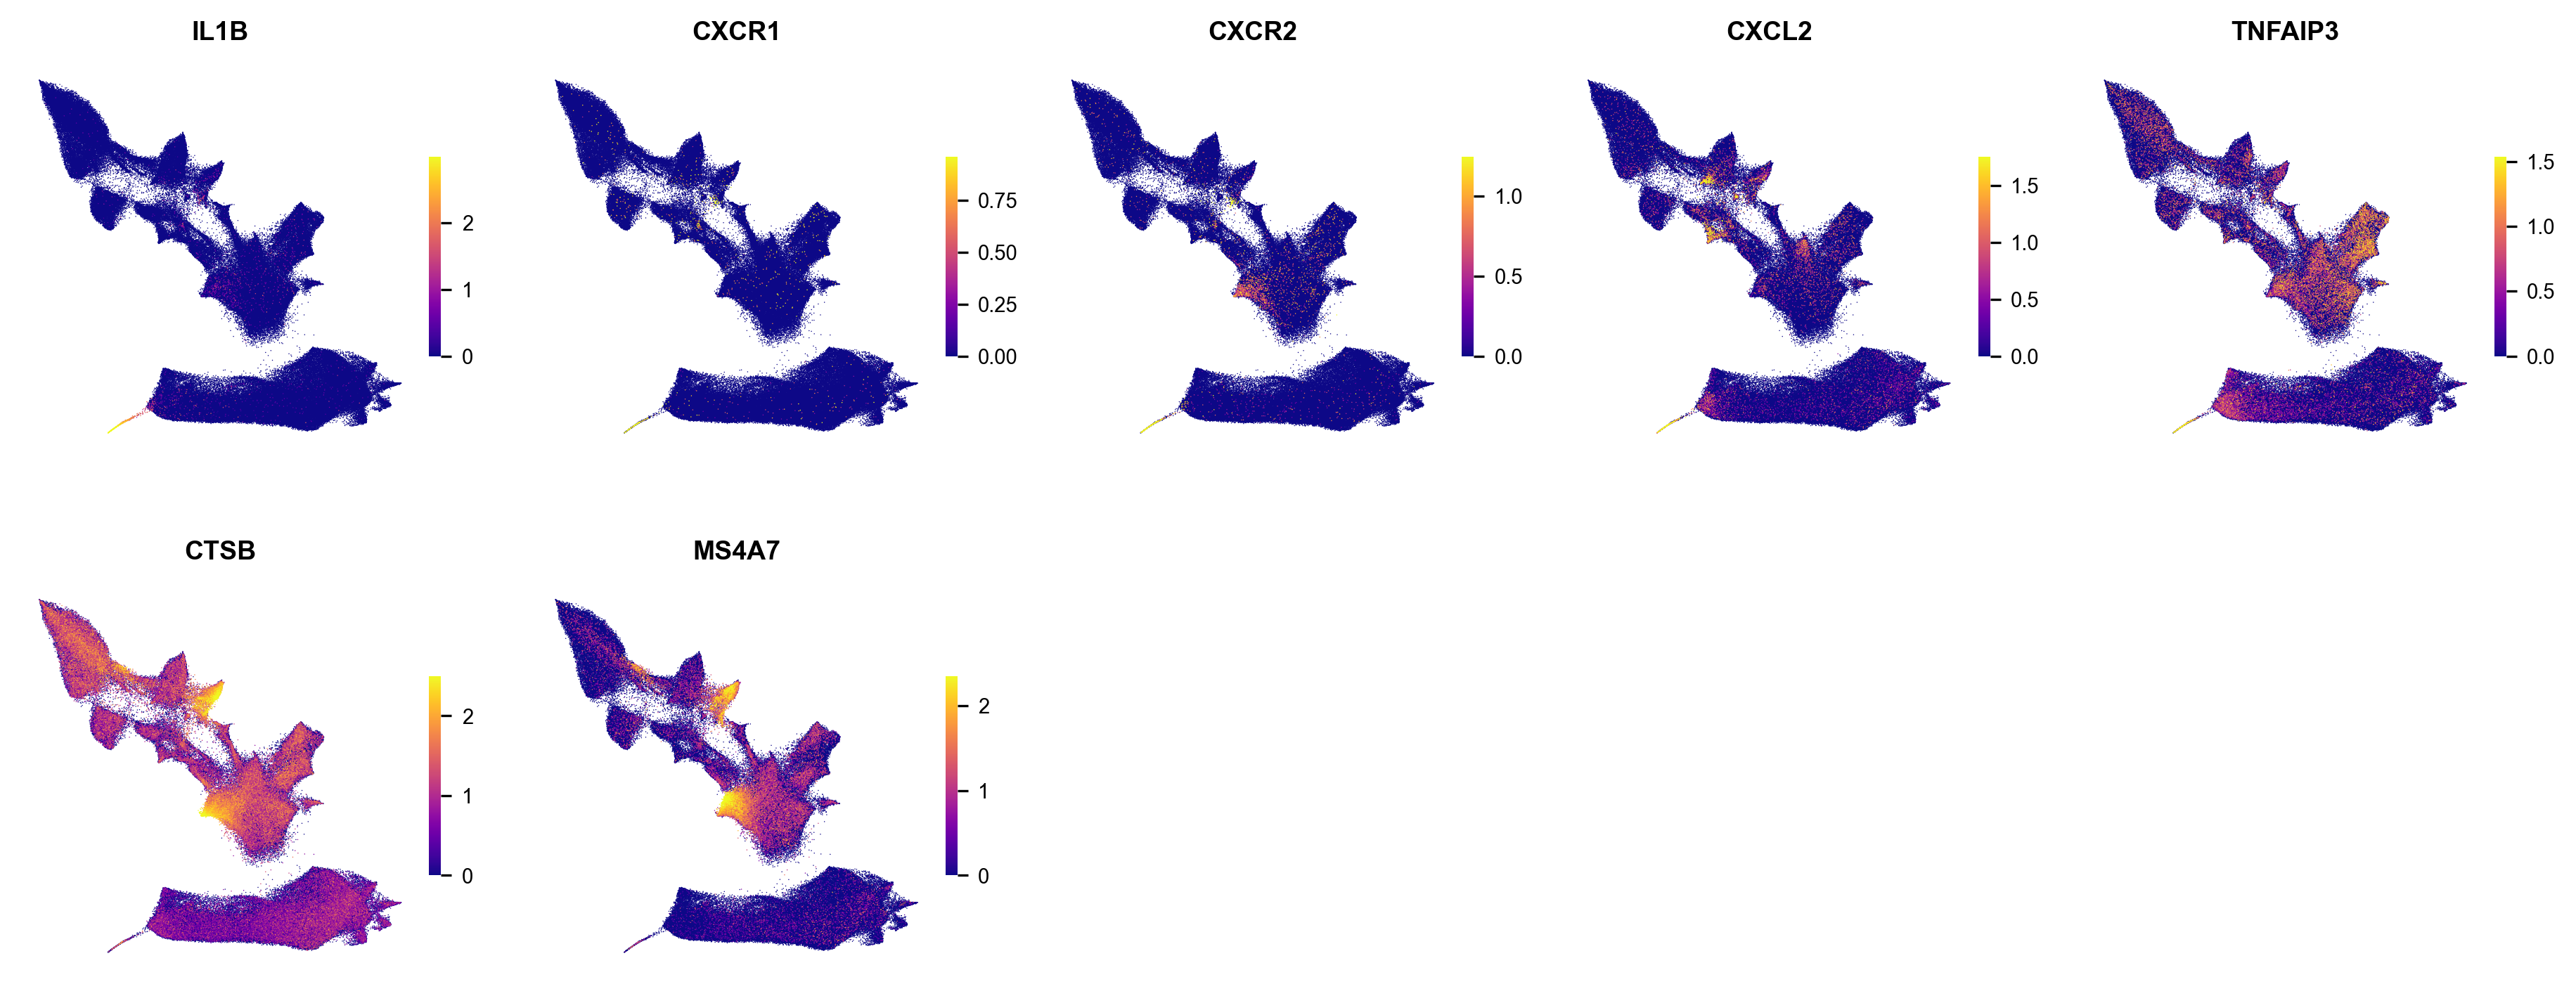

In [720]:
#fig, ax = plt.subplots(1, 1, figsize=(4,4))
_ = plot_embedding(
    ad_seg,
    ['IL1B', 'CXCR1', 'CXCR2', 'CXCL2', 'TNFAIP3', 'CTSB', 'MS4A7'],
    dim=2.5,
    s=0.5,
    #ax=ax,
    sort_order=True,
    vmin=0,
    layer='lognorm',
    legend_loc='on_data',
    legend_fontsize=3,
    #basis='X_spatial',
    vmax='p99.9',
)


In [686]:
ad_seg.X = ad_seg.layers['lognorm']
sc.tl.rank_genes_groups(
    ad_seg,
    'phenograph_cluster',
    method='wilcoxon',
    use_raw=False,
)

In [718]:
genes = sc.get.rank_genes_groups_df(ad_seg, '10').head(10)['names'].tolist()

In [719]:
', '.join(genes)

'CTSB, MS4A7, C1QC, CYBB, MAF, DNASE1L3, C1QA, RNASE1, CD163, CD14'

In [550]:
df[df['group'].str.contains('yof').fillna(False)]

gene          label compartment                  source          group
1888  NPNT  myofibroblast     stromal  Elmentaite et al, 2021  Myofibroblast
1889  HHIP  myofibroblast     stromal  Elmentaite et al, 2021  Myofibroblast

In [304]:
markers.loc[markers['gene'].isin(genes)]

Unnamed: 0      gene                     label compartment  \
26           27     BEST4      paneth cell of colon  epithelial   
36           37       CA4      paneth cell of colon  epithelial   
37           38       CA7      paneth cell of colon  epithelial   
67           68   CEACAM5    BEST4+ epithelial cell  epithelial   
77           78      CHP2           absorptive cell  epithelial   
138         142  HEPACAM2         colon goblet cell  epithelial   
275         284      SPIB      paneth cell of colon  epithelial   
318         327     BEST4    BEST4+ epithelial cell  epithelial   
321         330       CA4    BEST4+ epithelial cell  epithelial   
322         331       CA7    BEST4+ epithelial cell  epithelial   
353         362      SPIB    BEST4+ epithelial cell  epithelial   
379          11     BEST4        Enterocytes BEST4+  epithelial   
380          11       CA7        Enterocytes BEST4+  epithelial   
381          11       CA4        Enterocytes BEST4+  epithelial   
382          11      SPIB        Enterocytes BEST4+  epithelial   
424          26   CEACAM5  Goblet cells MUC2+ TFF1+  epithelial   
523          30     BEST4         BEST4+ epithelial  epithelial   
524          31       CA7         BEST4+ epithelial  epithelial   
526          33       CA4         BEST4+ epithelial  epithelial   
532          48      SPIB         BEST4+ epithelial  epithelial   
582         423  HEPACAM2     Progenitor (NEUROG3+)  epithelial   
649        1133      SPIB                       FDC     stromal   
733        2130      PIGR           IgA plasma cell      immune   
734        2138      KRT8           IgA plasma cell      immune   
738        2156     EPCAM           IgA plasma cell      immune   
812        3049      SPIB                       pDC      immune   
835        3458       CA4        arterial capillary     stromal   

                     source                      group  
26             10X Genomics                Paneth Cell  
36             10X Genomics                Paneth Cell  
37             10X Genomics                Paneth Cell  
67             10X Genomics     BEST4+ Epithelial Cell  
77             10X Genomics  Absorptive Precursor Cell  
138            10X Genomics                Goblet Cell  
275            10X Genomics                Paneth Cell  
318            10X Genomics     BEST4+ Epithelial Cell  
321            10X Genomics     BEST4+ Epithelial Cell  
322            10X Genomics     BEST4+ Epithelial Cell  
353            10X Genomics     BEST4+ Epithelial Cell  
379        Kong et al, 2023     BEST4+ Epithelial Cell  
380        Kong et al, 2023     BEST4+ Epithelial Cell  
381        Kong et al, 2023     BEST4+ Epithelial Cell  
382        Kong et al, 2023     BEST4+ Epithelial Cell  
424        Kong et al, 2023                Goblet Cell  
523  Elmentaite et al, 2021     BEST4+ Epithelial Cell  
524  Elmentaite et al, 2021     BEST4+ Epithelial Cell  
526  Elmentaite et al, 2021     BEST4+ Epithelial Cell  
532  Elmentaite et al, 2021     BEST4+ Epithelial Cell  
582  Elmentaite et al, 2021                        NaN  
649  Elmentaite et al, 2021                        NaN  
733  Elmentaite et al, 2021                        NaN  
734  Elmentaite et al, 2021                        NaN  
738  Elmentaite et al, 2021                        NaN  
812  Elmentaite et al, 2021                        NaN  
835  Elmentaite et al, 2021                        NaN

In [151]:
ct_map.idxmax(1)[ct_map.idxmax(1).str.contains('LEC')]

61    LEC6 (ADAMTS4+)
69    LEC2 (MADCAM1+)
dtype: object

In [131]:
ct_map = sc.get.aggregate(ad, gb, fn, obsm='X_cell_type').to_df(layer=fn)

In [479]:
from scipy.cluster.hierarchy import linkage, fcluster

signatures = (df['label'] + ', ' + df['source']).unique()
correlations = np.corrcoef(ad.obs[signatures].T)


In [480]:
clusters = fcluster(
    linkage(correlations, method='average'),
    1.5,
    criterion='distance'
)

In [561]:
signatures[['Endo' in s for s in signatures]]

array(['Endothelial cells CA4+ CD36+, Kong et al, 2023',
       'Endothelial cells CD36+, Kong et al, 2023',
       'Endothelial cells DARC+, Kong et al, 2023'], dtype=object)

In [551]:
# Ignore performance warnings from calling insert
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Score all genes
ad.X = ad.layers['z-score']
for name, group in df.groupby('group'):
    sc.tl.score_genes(
        adata=ad,
        gene_list=group['gene'],
        score_name=name,
        use_raw=False,
    )

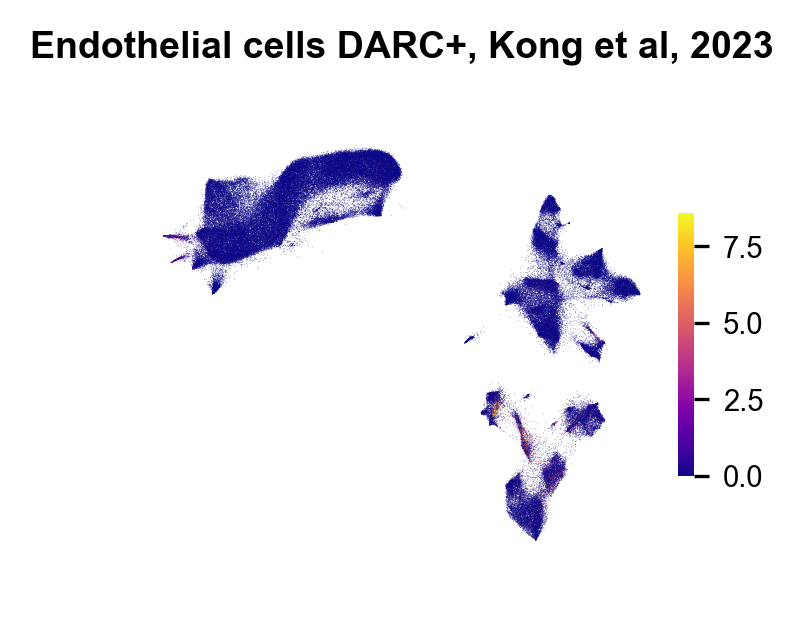

In [562]:
_ = plot_embedding(
    ad,
    ['Endothelial cells DARC+, Kong et al, 2023'],
    dim=2.5,
    s=0.1,
    sort_order=False,
    vmin=0,
    vmax='p99.9',
    layer='z-score',
)

In [448]:
df_agg = sc.get.aggregate(
    ad,
    by='phenograph_cluster',
    func='mean',
    obsm='X_sig',
).to_df(layer='mean')

In [ ]:
Index(['follicular B cell, 10X Genomics', 'Naive B, Elmentaite et al, 2021'], dtype='object')
Index(['STAT1+ Naive B, Elmentaite et al, 2021'], dtype='object')
Index(['memory B cell, 10X Genomics', 'B cell, 10X Genomics',
       'B cells, Kong et al, 2023', 'FDC, Elmentaite et al, 2021',
       'LZ GC cell, Elmentaite et al, 2021'],
      dtype='object')
Index(['B cells AICDA+ LRMP+, Kong et al, 2023',
       'DZ GC cell, Elmentaite et al, 2021', 'pDC, Elmentaite et al, 2021'],
      dtype='object')
Index(['IgA plasma cell, 10X Genomics', 'Plasma cells, Kong et al, 2023'], dtype='object')

In [ ]:


'IgA plasma cell, 10X Genomics', 'Plasma cells, Kong et al, 2023',

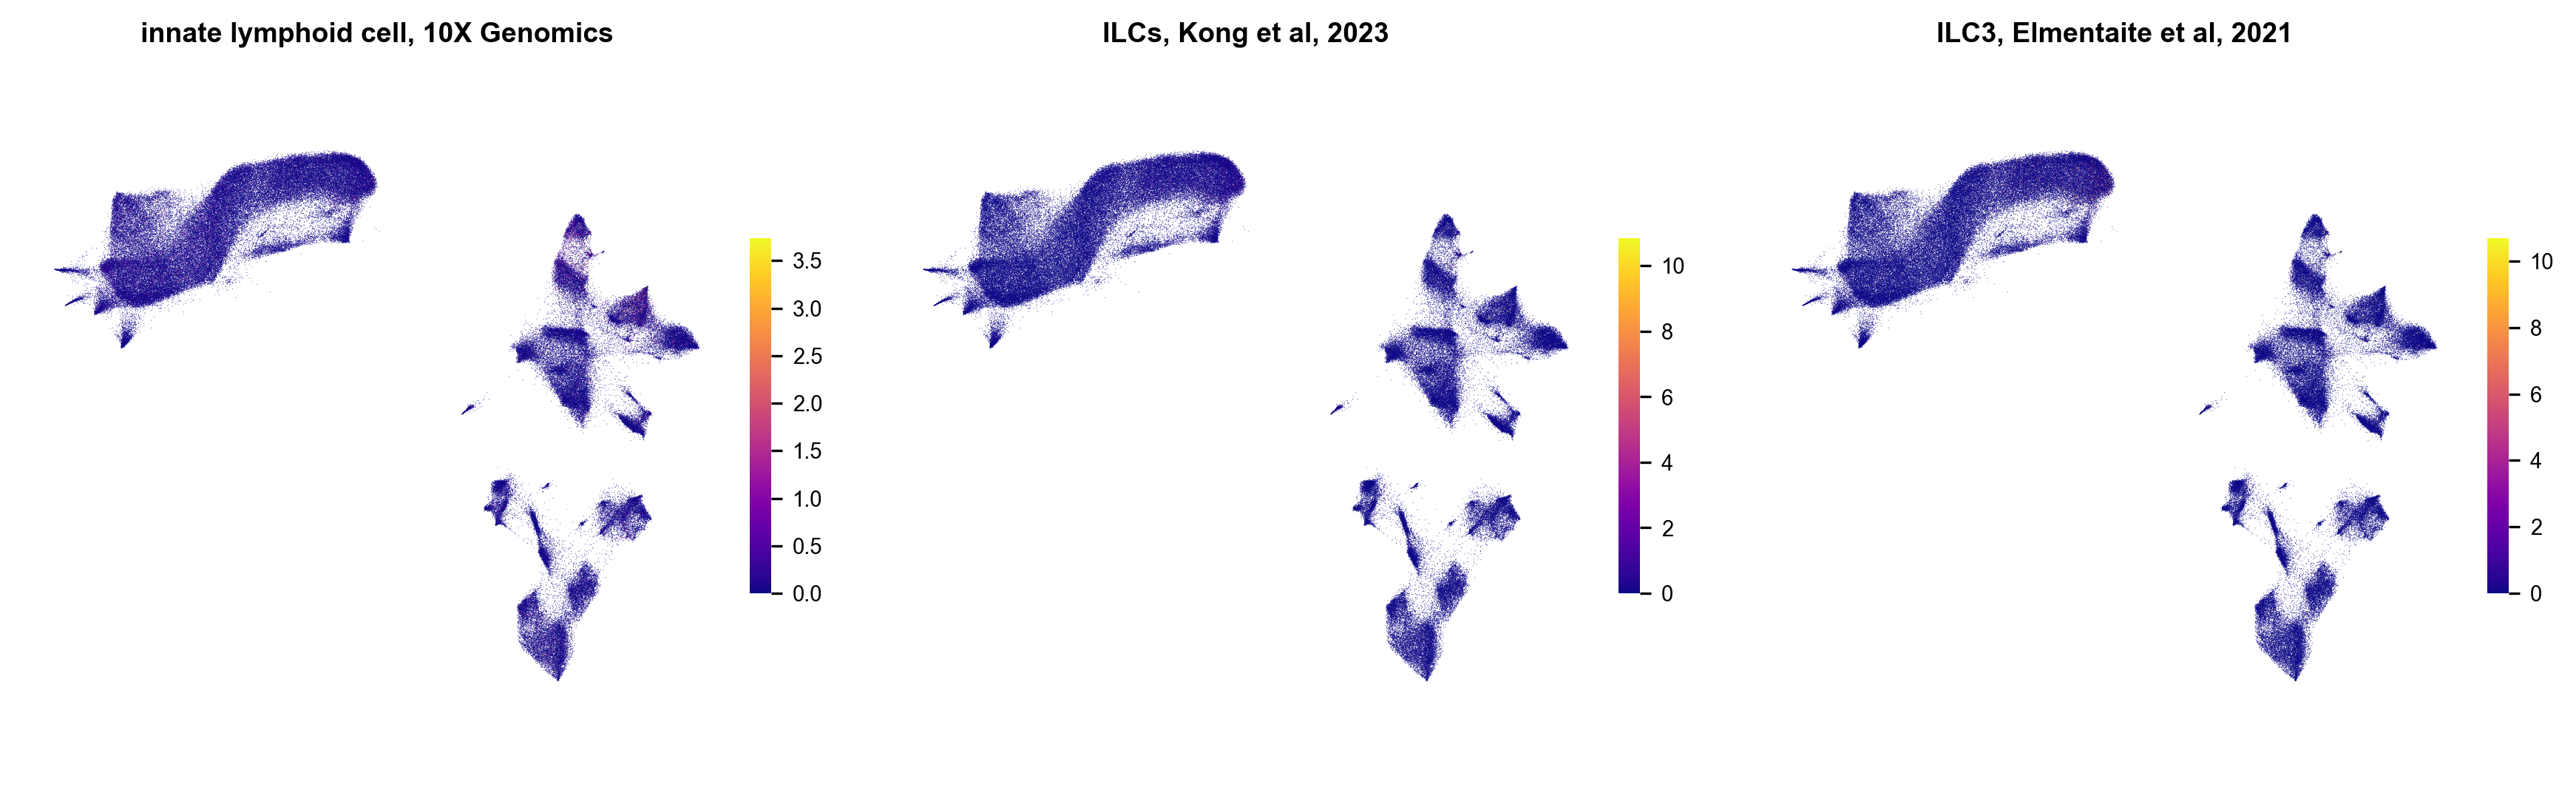

In [533]:
_ = plot_embedding(
    ad,
    [
       'innate lymphoid cell, 10X Genomics', 'ILCs, Kong et al, 2023',
       'ILC3, Elmentaite et al, 2021'
        
    ],
    dim=4,
    s=0.2,
    sort_order=False,
    vmin=0,
    vmax='p99.9',
    layer='z-score',
)

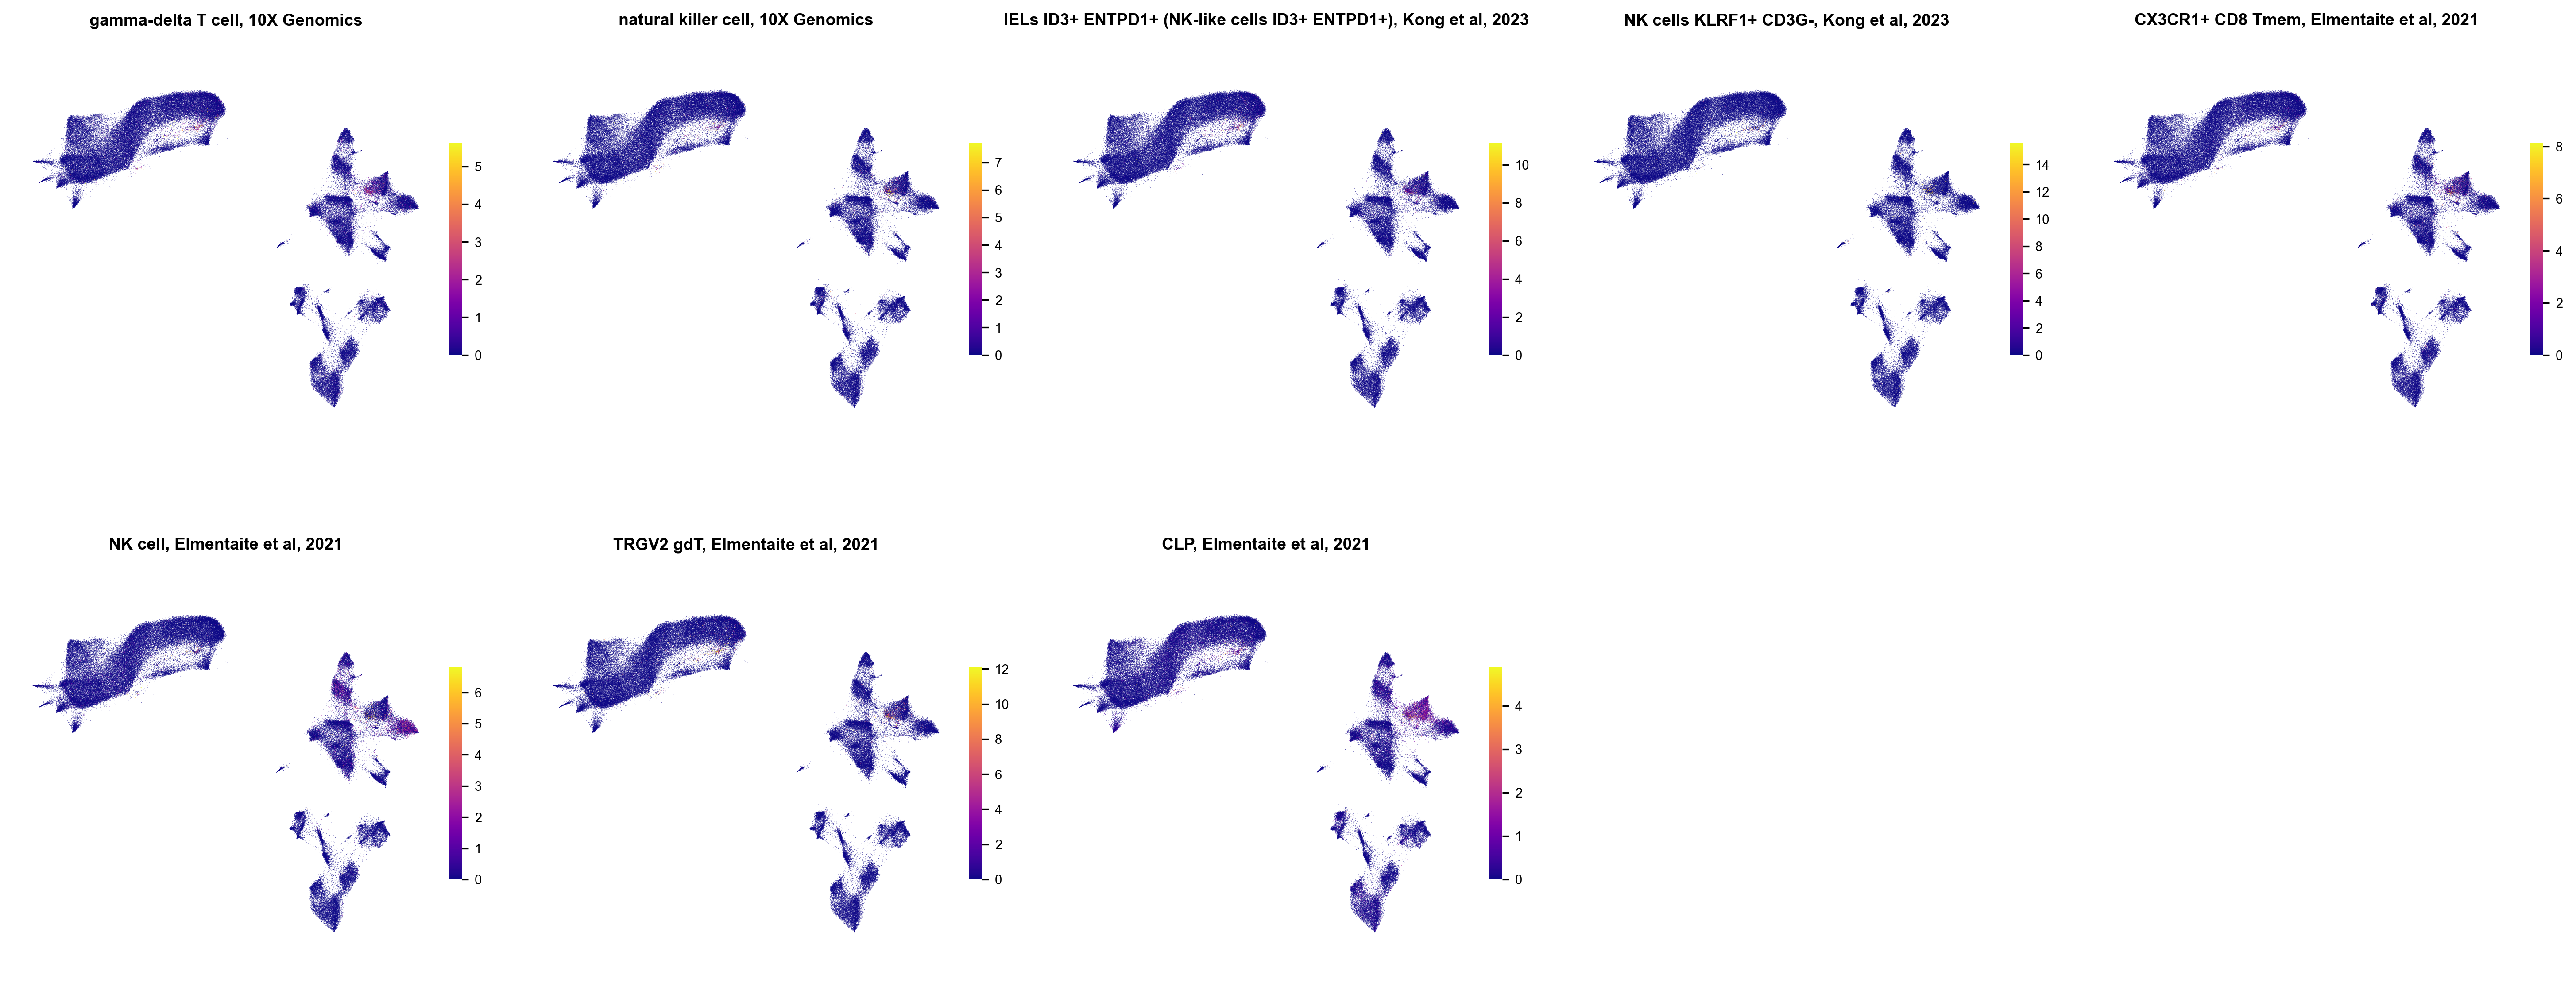

In [522]:
_ = plot_embedding(
    ad,
    [
       'gamma-delta T cell, 10X Genomics', 'natural killer cell, 10X Genomics',
       'IELs ID3+ ENTPD1+ (NK-like cells ID3+ ENTPD1+), Kong et al, 2023',
       'NK cells KLRF1+ CD3G-, Kong et al, 2023',
       'CX3CR1+ CD8 Tmem, Elmentaite et al, 2021',
       'NK cell, Elmentaite et al, 2021', 'TRGV2 gdT, Elmentaite et al, 2021',
       'CLP, Elmentaite et al, 2021'
        
    ],
    dim=4,
    s=0.2,
    sort_order=False,
    vmin=0,
    vmax='p99.9',
    layer='z-score',
)

In [452]:
col_idx = cm.dendrogram_col.dendrogram['leaves']
row_idx = cm.dendrogram_row.dendrogram['leaves']

In [477]:
clusters = sp.cluster.hierarchy.fcluster(
    cm.dendrogram_col.linkage, 1.5, criterion='distance',
)
len(np.unique(clusters))

63

<Axes: >

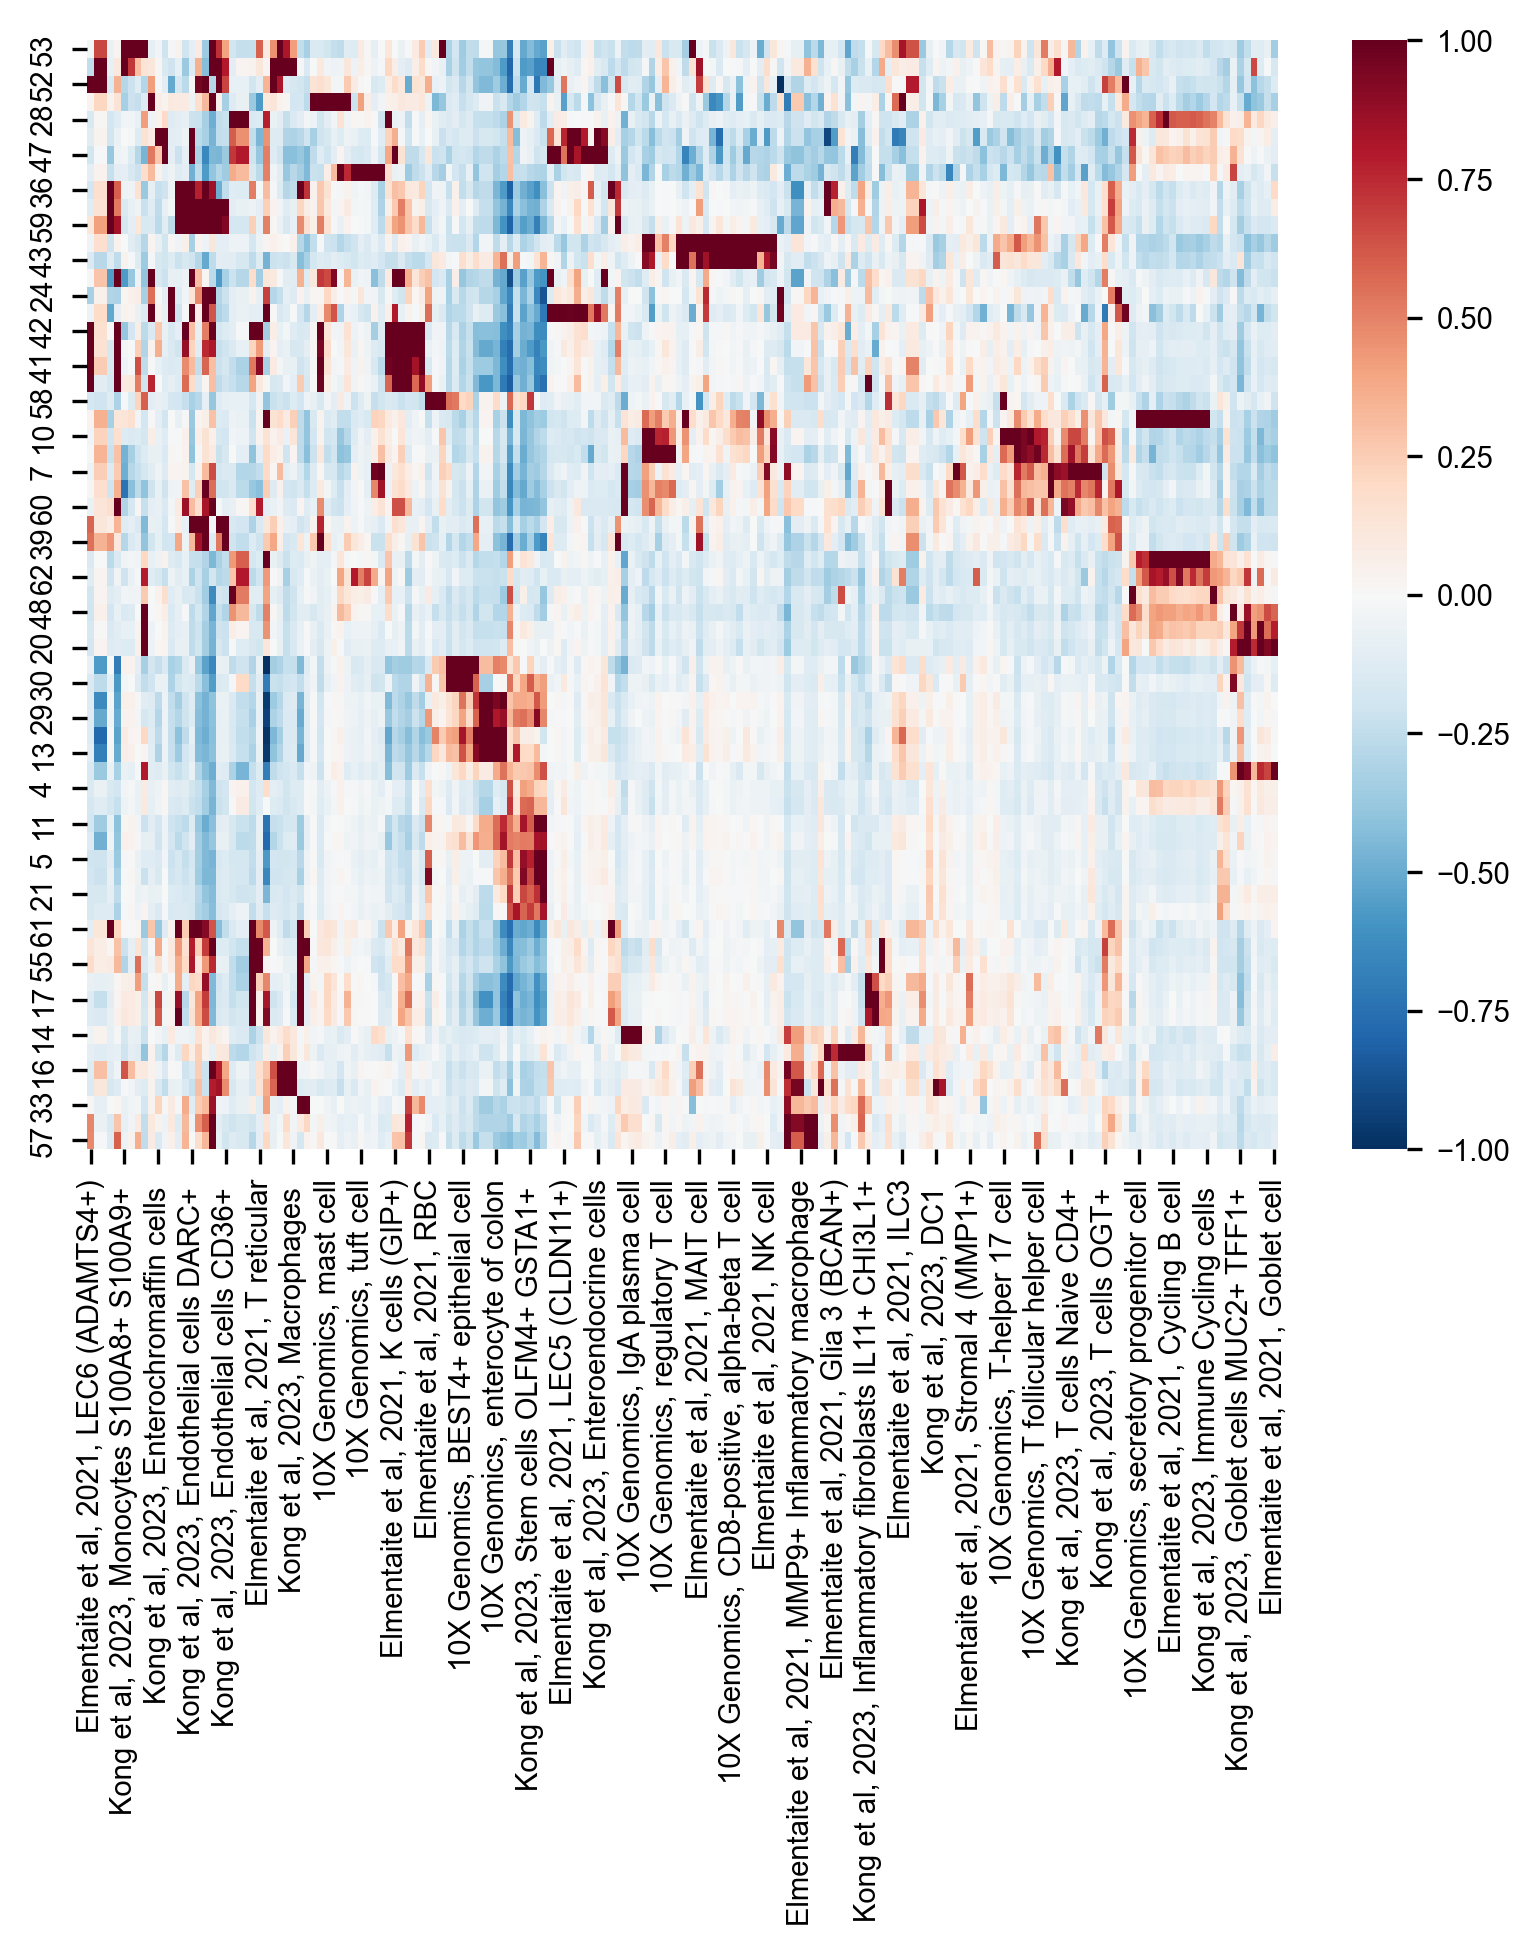

In [54]:
sns.heatmap(df_agg.iloc[row_idx, col_idx], vmax=1, vmin=-1, cmap='RdBu_r')

In [123]:
clusters

array([2, 2, 2, 3, 2, 2, 3, 6, 2, 2, 4, 2, 3, 2, 5, 2, 5, 3, 3, 3, 2, 2,
       3, 2, 3, 2, 3, 6, 2, 2, 2, 2, 5, 3, 4, 2, 3, 1, 3, 3, 1, 3, 3, 5,
       4, 3, 2, 1, 2, 6, 6, 3, 3, 5, 4, 3, 3, 3, 2, 3, 6, 3, 2],
      dtype=int32)

In [127]:
ad.obs['cluster_group'] = ad.obs['phenograph_cluster'].map(dict(zip(df_agg.index.astype(int), clusters))).astype(str)

In [201]:
# Read in CellTypist model and annotate
filepath = data_dir / dataset / 'colon_celltypist_model_groups.pkl'
ct_model = ct.Model.load(str(filepath))
annotate_cell_types(ad, ct_model, target_sum=150, suffix='group')

In [304]:
# Split into compartment and cell type each
for compartment, group in compartments.items():

    # Subset anndata to compartment
    col = 'celltypist_label_cluster_group'
    is_comp = ad.obs[col].isin(compartments[compartment])
    ad_comp = ad[is_comp].copy()
    
    # Reprocess compartment cells only
    preprocess_rapids(
        ad_comp,
        filter_min_counts=20,
        pca_total_var=0.9,
        umap_min_dist=0.1,
        umap_n_epochs=2000,
        pca_layer='norm',
        knn_neighbors=5,
        phenograph_resolution=3,  # finer-grained clustering for cell typing
    )
    
    # Read in Celltypist model and annotate
    filename = f'colon_celltypist_model_{compartment.lower()}.pkl'
    filepath = data_dir / dataset / filename
    ct_model = ct.Model.load(str(filepath))
    annotate_cell_types(ad_comp, ct_model, target_sum=150)
    
    # For cell compartments with matching 10X labels
    in_10x = annot.group.isin(group)
    if in_10x.any():
        
        # Score cell types
        X = ad_comp.layers['lognorm'].todense().A
        ad_comp.layers['z-score'] = sp.stats.zscore(X, axis=0)
        ad_comp.X = ad_comp.layers['z-score']
        for name, gp in annot[in_10x].groupby('cell_type'):
            sc.tl.score_genes(
                ad_comp,
                gp.gene,
                use_raw=False,
                score_name=name,
            )
    
        # Label with max score
        score_cols = annot[in_10x].cell_type.unique()
        ad_comp.obs['max_scoring'] = ad_comp.obs[score_cols].idxmax(1)
    
        # Rebuild celltypist model
        mask = ad_comp.obs['max_scoring'] != ad_comp.obs['celltypist_label']
        ad_comp.obs.loc[mask, 'celltypist_label'] = np.nan
        ct_model_comp = build_celltypist_model(
            ad_comp,
            celltype_col='celltypist_label',
            raw_layer='raw',
            target_sum=100,
            sample_size=1000,
        )
    
        # Relabel cells
        annotate_cell_types(
            ad_comp,
            ct_model=ct_model_comp,
            target_sum=100,
        )
    
    # Remap labels back to AnnData
    for col in [
        'celltypist_label',
        'celltypist_label_cluster',
    ]:
        ad.obs[col] = ad.obs[col].astype(str)
        ad.obs.loc[ad_comp.obs.index, col] = ad_comp.obs[col].astype(str)

# Save to file
ad.write_h5ad(data_dir / dataset / f'h5ads/{seg_col}_annotated.h5ad')

Done: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]         
... storing 'celltypist_label' as categorical
... storing 'celltypist_label_cluster' as categorical


## Create and Annotate AnnData from Nuclear Transcripts

### Transcripts to AnnData

In [196]:
# Read in all transcripts
transcripts_filepath = data_dir / dataset / 'labeled_transcripts.parquet'
transcripts = pd.read_parquet(transcripts_filepath)

# Filter control probes and low QV probes
xe_settings = load_settings('xenium')
transcripts = filter_transcripts(
    transcripts,
    label=xe_settings.transcripts.label,
    filter_substrings=xe_settings.transcripts.filter_substrings,
    min_qv=25,
)

In [355]:
# Subset Segger data to high-confidence transcripts
seg_col = 'nucleus_id'
mask = transcripts['overlaps_nucleus'].eq(1)

# Transcripts to anndata
ad = anndata_from_transcripts(
    transcripts[mask],
    cell_label=seg_col,
    gene_label='feature_name',
    coordinate_labels=['x_location', 'y_location'],
)

# Add raw counts before filtering
ad.uns['raw_counts'] = dict(
    index=ad.obs.index.tolist(),
    count=ad.raw.X.A.sum(1),
)

In [362]:
ad.write_h5ad(data_dir / dataset / f'h5ads/{seg_col}_hi_thresh.h5ad')

In [356]:
# Preprocess and save
thresh = 25
preprocess_rapids(
    ad,
    filter_min_counts=thresh,
    pca_total_var=0.9,
    umap_min_dist=0.1,
    umap_n_epochs=5000,
    pca_layer='norm',
    knn_neighbors=30,
    phenograph_resolution=2,
)

# Save to file
#ad.write_h5ad(data_dir / dataset / f'h5ads/{seg_col}_lo_thresh.h5ad')

Done: 100%|██████████| 6/6 [00:43<00:00,  7.31s/it]         


In [247]:
# Get most frequent nucleus label for each segger cell label
seg_col = 'segger_cell_id_k=20'
ad_seg = sc.read_h5ad(data_dir / dataset / f'h5ads/{seg_col}_annotated.h5ad')

counts = transcripts.value_counts([seg_col, 'nucleus_id'])
nuc_map = counts.groupby(seg_col).idxmax().str[1]
ad_seg.obs['nucleus_id'] = ad_seg.obs.index.astype(float).map(nuc_map)

In [156]:
ct_map.index.duplicated(keep='first')

array([False, False, False, ...,  True, False, False])

In [218]:
ad_seg = ad_seg[ad_seg.obs['celltypist_label_cluster_group'].eq('Epithelial Cell')]

In [255]:
ct_map = ad_seg.obs.set_index('nucleus_id')['celltypist_label']
ct_map = ct_map[~ct_map.index.duplicated()]
ad.obs['celltypist_label'] = ct_map
ad.obs['is_tuft'] = ad.obs['celltypist_label'] == 'Tuft Cell'

In [249]:
ad_seg.obs['is_tuft'] = ad_seg.obs['celltypist_label'] == 'Tuft Cell'

In [202]:
ad.obs['is_epi'] = ad.obs['celltypist_label_cluster_group'].eq('Epithelial Cell')

In [206]:
is_epi = ad.obs.groupby('phenograph_cluster')['is_epi'].mean().gt(0.8)
ad.obs['is_epi'] = ad.obs['phenograph_cluster'].map(is_epi)

In [207]:
ad = ad[ad.obs['is_epi']]

In [157]:
ad.obs['in_segger'] = ad.obs.index.isin(ad_seg.obs['nucleus_id']).astype(int)
mask = ad_seg.obs['phenograph_cluster'].eq(30)
ad.obs['is_neutrophil'] = pd.Categorical(
    ad.obs.index.isin(ad_seg.obs.loc[mask, 'nucleus_id']),
    categories=[False, True],
    ordered=True
)

ct_map = ad_seg.obs.set_index('nucleus_id')['celltypist_label']
ct_map = ct_map[~ct_map.index.duplicated()]
ad.obs['celltypist_label'] = ct_map

In [158]:
rows = []
for name, group in tqdm(ad.obs.groupby('phenograph_cluster')):
    counts = ad.obs.loc[group.index, 'n_counts'].mean()
    covs = np.corrcoef(ad[group.index].layers['lognorm'].todense().A.T)
    covs = np.mean(np.abs(np.nan_to_num(covs, 0)))
    frac = ad.obs.loc[group.index, 'in_segger'].mean()
    rows.append([name, covs, frac, counts])

df = pd.DataFrame(rows, columns=['cluster', 'covariance', 'fraction', 'counts'])

100%|██████████| 60/60 [00:01<00:00, 43.01it/s]


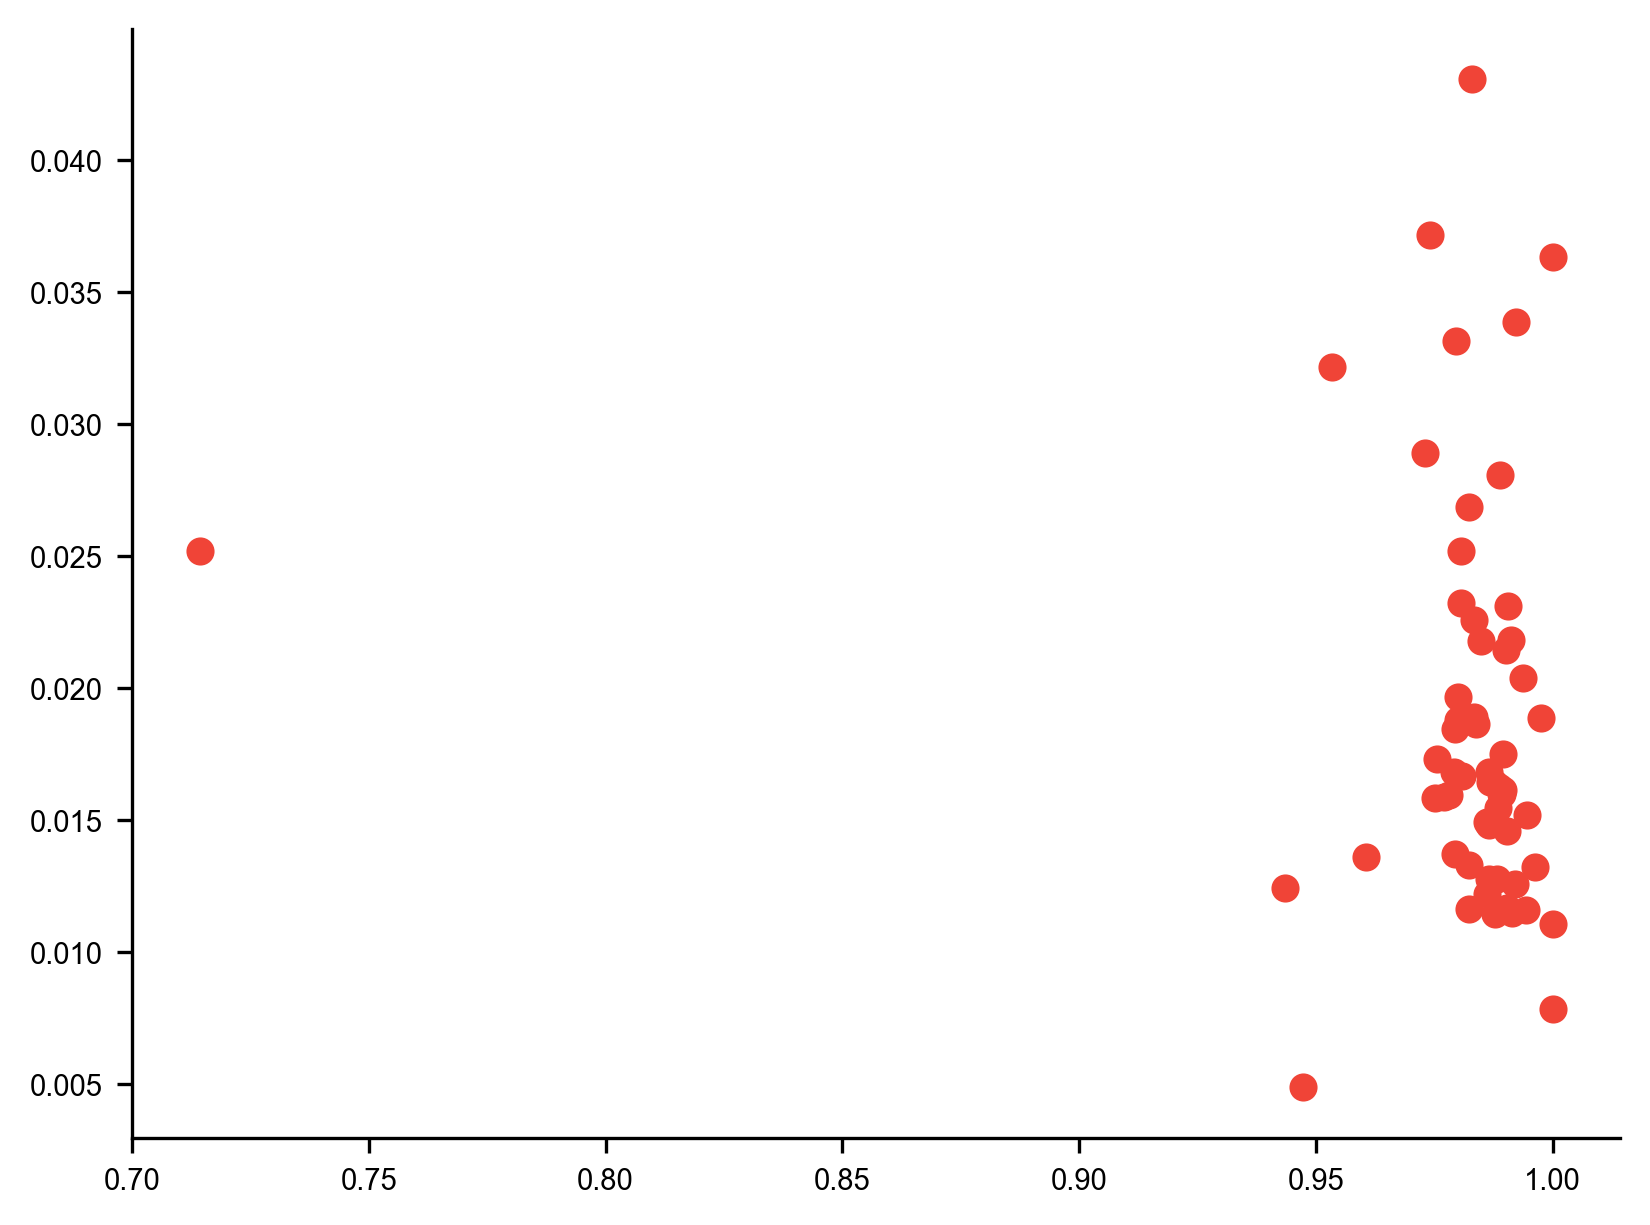

In [159]:
plt.scatter(
    df['fraction'],
    df['covariance'],
)

In [320]:
ad_seg.obs['is_neutrophil'] = ad_seg.obs['phenograph_cluster'].eq(38)

In [357]:
col = 'is_neutrophil'
ct_map = ad_seg.obs.set_index('nucleus_id')[col]
ct_map = ct_map[~ct_map.index.duplicated()]
ad.obs[col] = ct_map
ad.obs[col] = pd.Categorical(ad.obs[col].fillna(False))

In [351]:
mask = ad_seg.obs[col]
knn = ad_seg.obsp['connectivities'][mask].T[mask].T.sum(1)
np.mean(knn) / 30

0.9495944380069525

In [358]:
mask = ad.obs[col]
knn = ad.obsp['connectivities'][mask].T[mask].T.sum(1)
np.mean(knn) / 30

0.5928571428571429

In [316]:
sp.stats.entropy(ad.obs.loc[ad.obs['is_tuft'], 'phenograph_cluster'].value_counts())

1.4694760239607902

In [315]:
sp.stats.entropy(ad_seg.obs.loc[ad_seg.obs['is_tuft'], 'phenograph_cluster'].value_counts())

0.22868114357936775

In [359]:
ad_seg.obs[col].sum()

863

In [361]:
ad.obs[col].astype(int).sum()

84

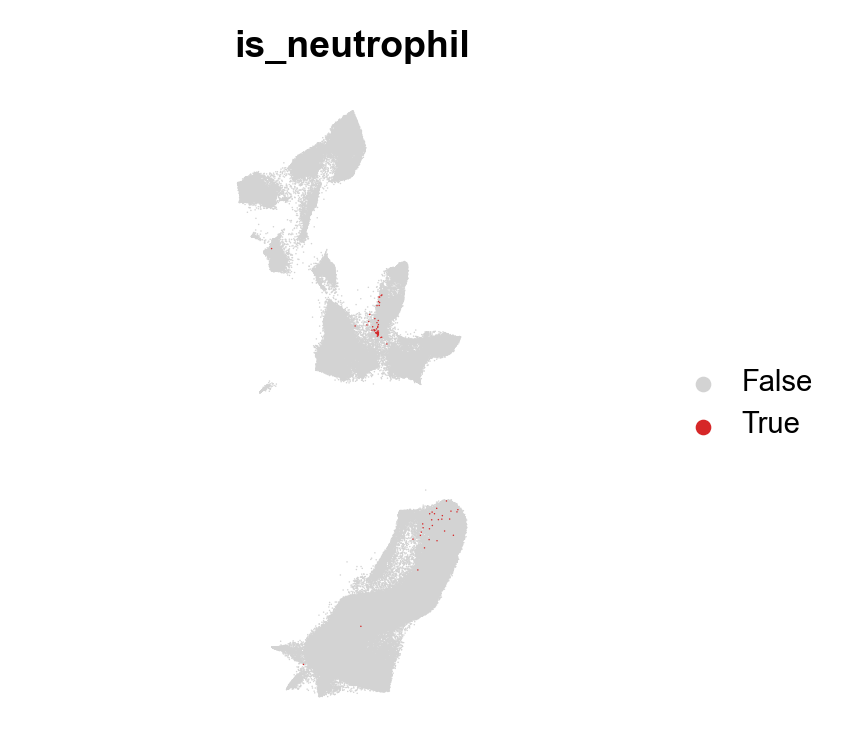

In [332]:
_ = plot_embedding(
    ad[ad.obs['is_neutrophil'].sort_values().index],
    ['is_neutrophil'],
    sort_order=False,
    s=0.1,
    dim=3,
    layer='lognorm',
    palette=['lightgray', 'tab:red'],
    #legend_loc='on data',
)

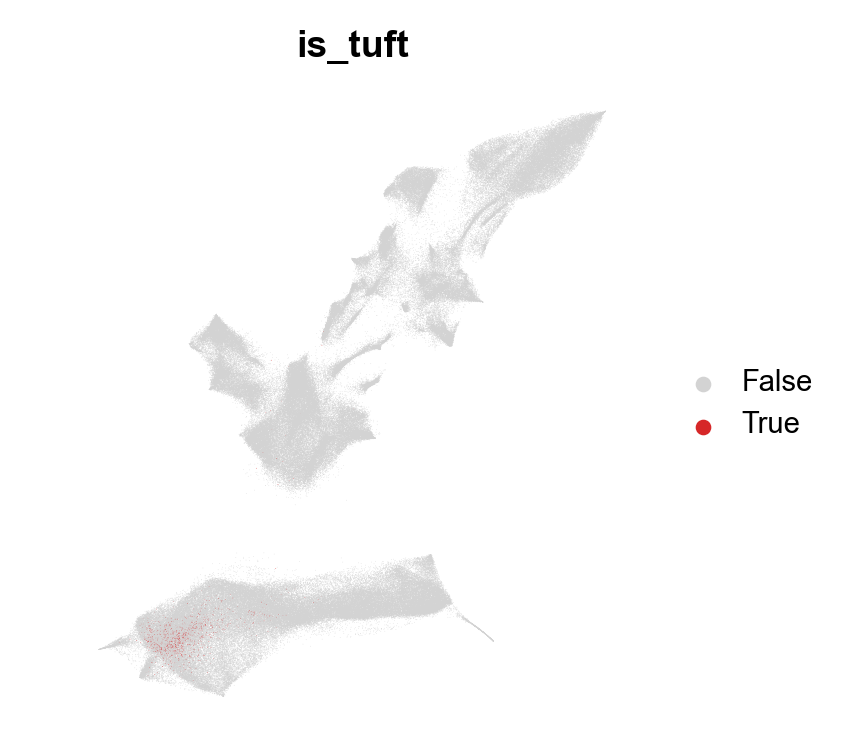

In [347]:
_ = plot_embedding(
    ad,
    ['is_tuft'],
    sort_order=False,
    s=0.1,
    dim=3,
    layer='lognorm',
    palette=['lightgray', 'tab:red'],
    #legend_loc='on data',
)

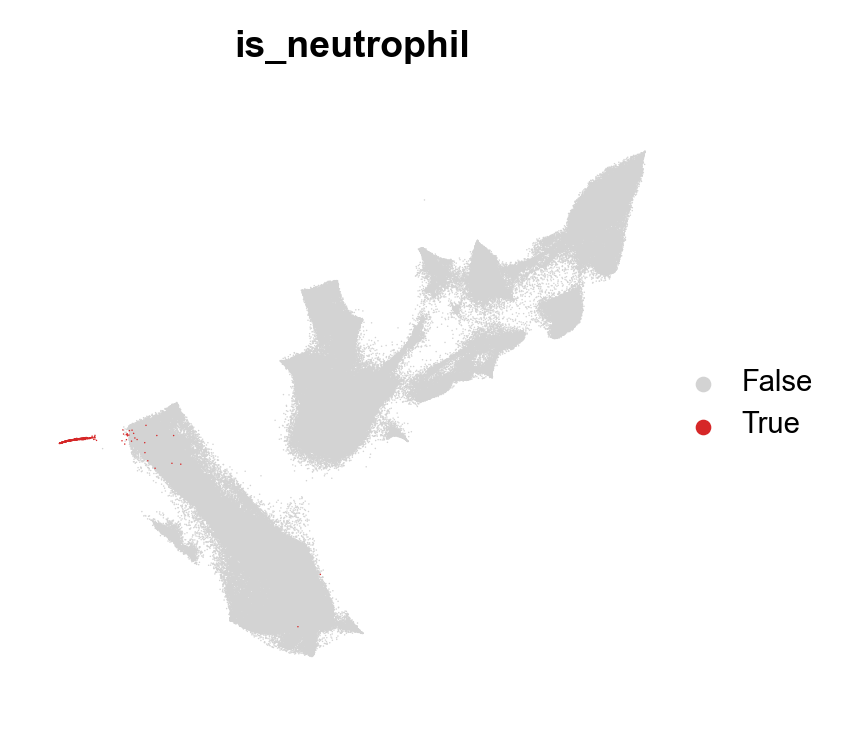

In [353]:
_ = plot_embedding(
    ad_seg[ad_seg.obs['is_neutrophil'].sort_values().index],
    ['is_neutrophil'],
    sort_order=False,
    s=0.5,
    dim=3,
    layer='lognorm',
    palette=['lightgray', 'tab:red'],
    #legend_loc='on data',
)

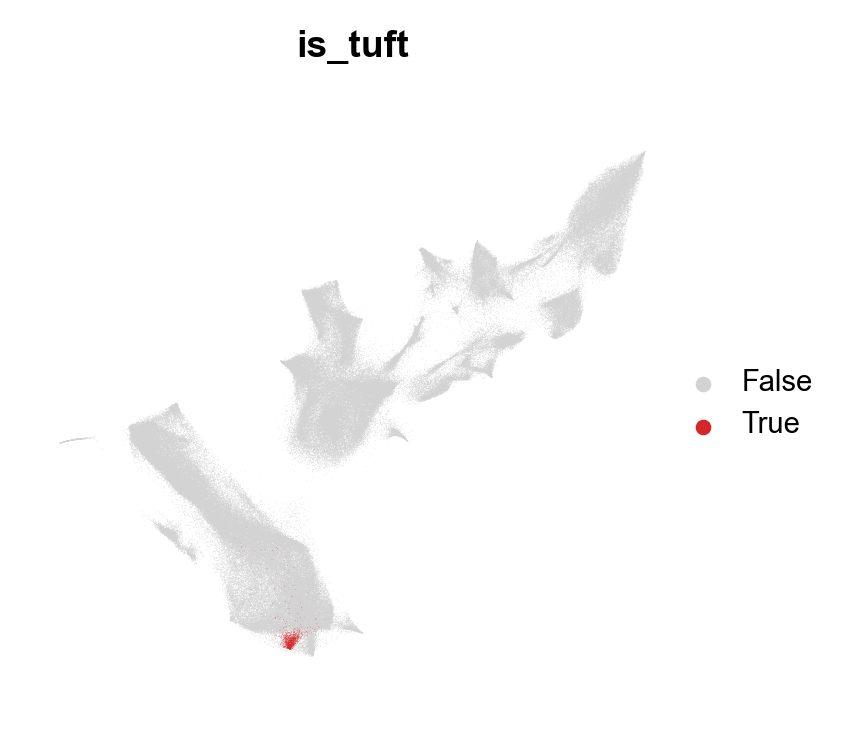

In [339]:
_ = plot_embedding(
    ad_seg, #[ad_seg.obs['is_tuft'].sort_values().index],
    ['is_tuft'],
    sort_order=False,
    s=0.1,
    dim=3,
    layer='lognorm',
    palette=['lightgray', 'tab:red'],
    #legend_loc='on data',
)

## Build Celltypist Models

In [8]:
# Read in single cell atlas and 10X marker annotations
filepath = data_dir / dataset / 'h5ads/human_colon_atlas_subset.h5ad'
ad_atlas = sc.read_h5ad(filepath)

### Cell Type Groups

In [9]:
# Groupings of coarse cell types
ct_groups = {
    'B Cell': [
        'follicular B cell', 'germinal center B cell', 'naive B cell',
        'memory B cell', 'B cell'
    ],
    'Endothelial Cell': [
        'vein endothelial cell', 'endothelial cell of lymphatic vessel',
        'endothelial cell of artery', 'capillary endothelial cell'
    ],
    'Epithelial Cell': [
        'transit amplifying cell', 'enterocyte', 'tuft cell of colon', 
        'goblet cell', 'BEST4+ intestinal epithelial cell, human', 
        'paneth cell', 'enterocyte of epithelium of large intestine',
        'enteroendocrine cell', 'stem cell'
    ],
    'Mesenchymal Cell': [
        'stromal cell', 'myofibroblast cell', 'pericyte'
    ],
    'Myeloid Cell': [
        'macrophage', 'conventional dendritic cell', 'monocyte',
        'gastrointestinal tract (lamina propria) macrophage of large intestine',
        'mast cell',
    ],
    'Neuronal Cell': [
        'glial cell'
    ],
    'Plasma Cell': [
        'plasma cell'
    ],
    'T Cell': [
        'gamma-delta T cell', 'innate lymphoid cell', 'natural killer cell',
        'T-helper 17 cell', 'T follicular helper cell', 
        'central memory CD4-positive, alpha-beta T cell', 
        'regulatory T cell', 'effector memory CD4-positive, alpha-beta T cell',
        'T-helper 1 cell', 'effector memory CD8-positive, alpha-beta T cell',
    ]
}

# Remove cell types
ct_groups = {v: k for k, vals in ct_groups.items() for v in vals}
ad_atlas.obs['cell_type_group'] = ad_atlas.obs.cell_type.replace(ct_groups)

In [10]:
# Build Model
ct_model = build_celltypist_model(
    ad_atlas,
    celltype_col='cell_type_group',
    raw_layer='count',
    target_sum=100,
    sample_size=1000,
)
filepath = data_dir / dataset / 'colon_celltypist_model_groups.pkl'
ct_model.write(filepath)

### By Compartment

In [50]:
# Groupings of coarse cell types
ct_revised = {
    'B Cell': [
        'follicular B cell', 'germinal center B cell', 'naive B cell',
        'memory B cell', 'B cell'
    ],
    'T Cell': [
        'gamma-delta T cell', 'T-helper 17 cell', 'T follicular helper cell', 
        'central memory CD4-positive, alpha-beta T cell', 
        'regulatory T cell', 'effector memory CD4-positive, alpha-beta T cell',
        'T-helper 1 cell', 'effector memory CD8-positive, alpha-beta T cell',
        'natural killer cell', 'innate lymphoid cell',
    ],
    'Endothelial Cell': [
        'vein endothelial cell', 'endothelial cell of lymphatic vessel',
        'endothelial cell of artery', 'capillary endothelial cell'
    ],
    'Stromal Cell': [
        'stromal cell',
    ],
    'Myofibroblast Cell': [
        'myofibroblast cell',
    ],
    'Pericyte': [
        'pericyte',
    ],
    'Monocyte': [
        'monocyte',
    ],
    'Macrophage': [
        'macrophage',
        'gastrointestinal tract (lamina propria) macrophage of large intestine',
    ],
    'Mast Cell': [
        'mast cell',
    ],
    'Dendritic Cell': [
        'conventional dendritic cell',
    ],
    'Glial Cell': [
        'glial cell'
    ],
    'Plasma Cell': [
        'plasma cell'
    ],
    'Stem Cell': [
        'stem cell',
    ],
    'Transit Amplifying Cell': [
        'transit amplifying cell',
    ],
    'Tuft Cell': [
        'tuft cell of colon',
    ],
    'Goblet Cell': [
        'goblet cell',
    ],
    'Enteroendocrine Cell': [
        'enteroendocrine cell',
    ],
    'Enterocyte Cell': [
        'enterocyte',
        'enterocyte of epithelium of large intestine',
    ],
    'BEST4+ Enterocyte Cell': [
        'BEST4+ intestinal epithelial cell, human',
    ],
    'Paneth Cell': [
        'paneth cell',
    ],
}

# Remove cell types
ct_revised = {v: k for k, vals in ct_revised.items() for v in vals}
ad_atlas.obs['cell_type_revised'] = ad_atlas.obs.cell_type.replace(ct_revised)

In [51]:
# Split by compartment and rebuild celltypist models
compartments = {
    'Epithelial': ['Epithelial Cell',],
    'Immune': ['T Cell', 'B Cell', 'Myeloid Cell', 'Plasma Cell',],
    'Stromal': ['Mesenchymal Cell', 'Neuronal Cell', 'Endothelial Cell'],
}

for compartment, groups in compartments.items():
    is_comp = ad_atlas.obs.cell_type_group.isin(groups)
    ad_comp = ad_atlas[is_comp].copy()
    ct_model = build_celltypist_model(
        ad_comp,
        celltype_col='cell_type_revised',
        raw_layer='count',
        target_sum=150,
        sample_size=1000,
    )
    filename = f'colon_celltypist_model_{compartment.lower()}.pkl'
    ct_model.write(data_dir / dataset / filename)

In [228]:
# Build model for coefficients for cell type validations
ct_model = build_celltypist_model(
    ad_atlas,
    celltype_col='cell_type_revised',
    raw_layer='count',
    target_sum=100,
    sample_size=1000,
)
filepath = data_dir / dataset / 'colon_celltypist_model_all.pkl'
ct_model.write(filepath)

## Helper Functions

In [6]:
def annotate_cell_types(
    ad: sc.AnnData,
    ct_model: ct.Model,
    cluster_col: str = 'phenograph_cluster',
    target_sum: int = 1000,
    suffix: str = None,
):
    # Re-normalize consistent with CellTypist model
    t = target_sum
    ad.layers[f'norm_{t}'] = ad.raw.X.copy()
    sc.pp.normalize_total(ad, layer=f'norm_{t}', target_sum=t)
    ad.layers[f'lognorm_{t}'] = ad.layers[f'norm_{t}'].copy()
    if 'log1p' in ad.uns: del ad.uns['log1p']
    sc.pp.log1p(ad, layer=f'lognorm_{t}')
    
    # Cell type
    with HiddenPrints():
        ad.X = ad.layers[f'lognorm_{t}']
        preds = ct.annotate(
            ad, model=ct_model, majority_voting=True,
            over_clustering='phenograph_cluster',
            min_prop=0.2,
        )
    
    # Label AnnData
    suffix = '' if suffix is None else f'_{suffix}'
    ad.obs[f'celltypist_label{suffix}'] = preds.predicted_labels['predicted_labels']
    ad.obs[f'celltypist_label_cluster{suffix}'] = preds.predicted_labels['majority_voting']
    ad.obs[f'celltypist_probability{suffix}'] = preds.probability_matrix.max(1)
    for col in preds.probability_matrix.columns:
        ad.obs[f'{col}_probability'] = preds.probability_matrix[col]
    entropy = sp.stats.entropy(preds.probability_matrix, axis=1)
    ad.obs[f'celltypist_entropy{suffix}'] = entropy
    
    # Cleanup
    del ad.layers[f'lognorm_{t}'], ad.layers[f'norm_{t}']

In [5]:
def build_celltypist_model(
    ad_atlas: sc.AnnData,
    celltype_col: str, 
    raw_layer: str,
    target_sum: int = 1000,
    sample_size: int = 5000,
):
    # Re-normalize counts to 10K total
    t = target_sum
    ad_atlas.X = ad_atlas.layers[raw_layer].copy()
    sc.pp.downsample_counts(ad_atlas, counts_per_cell=t)
    ad_atlas.layers[f'norm_{t}'] = ad_atlas.X.copy()
    sc.pp.normalize_total(ad_atlas, layer=f'norm_{t}', target_sum=t)
    
    # Logarthmize
    ad_atlas.layers[f'lognorm_{t}'] = ad_atlas.layers[f'norm_{t}'].copy()
    if 'log1p' in ad_atlas.uns:
        del ad_atlas.uns['log1p']
    sc.pp.log1p(ad_atlas, layer=f'lognorm_{t}')
    
    # Subsample using more granular cell types (to not lose any one cell type)
    # But transfer labels using the compartment labels
    gb = ad_atlas.obs.groupby(celltype_col)
    sample = gb.sample(sample_size, replace=True).index.drop_duplicates()
    
    # Predict on log counts
    ad_atlas.X = ad_atlas.layers[f'lognorm_{t}']
    with HiddenPrints():
        ct_model = ct.train(
            ad_atlas[sample],
            labels=celltype_col,
            use_GPU=True,
            check_expression=False,
    )
    return ct_model

In [129]:
from sklearn.preprocessing import normalize
from cupyx.scipy.sparse import linalg
from cupyx import scipy as cusp
import cupy as cp
import cugraph
import cudf

def get_jaccard_index(
    A: cusp.sparse.csr_matrix, 
):
    '''
    description
    '''
    A = A.tocoo()
    edgelist = cudf.DataFrame(
        cp.array([A.row, A.col]).T,
        columns=['source', 'destination']
    )
    G = cugraph.from_cudf_edgelist(edgelist)
    J = cugraph.jaccard(G, edgelist)
    row, col, data = J.values.T
    J = cusp.sparse.csr_matrix((data, (row, col)))
    return J


def random_walk_probabilities_rapids(
    A: cusp.sparse.csr_matrix,
    labels: cp.ndarray,
    kernel: str = 'affinity',
):
    '''
    description
    '''
    # Inputs checks
    if labels.min() != 0:
        msg = (
            f"Labels should encode unlabeled points with 0s. Smallest label "
            f"value is {labels.min()}."
        )
        raise ValueError()
    if not isinstance(A, cusp.sparse.csr_matrix):
        A = cusp.sparse.csr_matrix(A)
    if not isinstance(labels, cp.ndarray):
        labels = cp.array(labels)

    # Graph laplacian form of jaccard index matrix
    if kernel == 'affinity':
        M = get_affinity(A)
    elif kernel == 'jaccard':
        M = get_jaccard_index(A)
    D = cusp.sparse.diags(M.sum(axis=1).flatten(), 0, shape=M.shape)
    L = D - M

    # Represent L as:
    # ⎡ Ll B  ⎤
    # ⎣ Bt Lu ⎦
    # Then, LuP = -BtQ

    # Unlabeled to unlabeled transitions
    labeled = labels != 0
    Lu = L[~labeled, :]  # unlabeled rows
    Lu = Lu.tocsc()[:, ~labeled]  # unlabeled columns

    Bt = L[~labeled, :]  # unlabeled rows
    Bt = Bt.tocsc()[:, labeled]  # labeled columns

    n = labeled.sum().item()
    i = cp.arange(n)
    j = labels[labeled] - 1
    s = cp.ones(n)
    Q = cusp.sparse.coo_matrix((s, (i, j)), shape=(n, labels.max())).tocsc()

    A = Lu.tocsr().get()
    B = -Bt.dot(Q).A.get()

    # Use iterative solver
    vals = []
    for b in B.T:
        vals.append(sp.sparse.linalg.bicgstab(A, b.T)[0])
    P = normalize(np.vstack(vals).T, norm='l1')
    
    return P


def phenograph_classify_rapids(
    ad: sc.AnnData,
    label_column: str,
    neighbors_key: str = None,
    kernel: str = 'affinity',
):

    # Get adjacency matrix and labels from AnnData
    if neighbors_key is None:
        neighbors_key = 'neighbors'

    if kernel == 'affinity':
        key = ad.uns[neighbors_key]['distances_key']
    elif kernel == 'jaccard':
        key = ad.uns[neighbors_key]['connectivities_key']
    A = cusp.sparse.csr_matrix(ad.obsp[key].astype('float32'))
    
    # Assume unlabeled samples have NaN in label column
    is_labeled = ~ad.obs[label_column].isna()
    
    # Get labels for known and unknown data
    labels = pd.Series(ad.obs.loc[is_labeled, label_column])
    lbl_codes, lbl_uniques = pd.factorize(labels)
    lbl_codes = np.append(
        np.zeros((np.sum(~is_labeled),), dtype=int),  # unlabeled is zero
        lbl_codes + 1
    )

    # Map labels using PhenoGraph classify on jaccard matrix
    P = random_walk_probabilities_rapids(A, cp.array(lbl_codes), kernel=kernel)
    c = np.argmax(P, axis=1)

    # Annotate AnnData
    c_map = dict(enumerate(lbl_uniques))
    ad.obs.loc[~is_labeled, label_column] = pd.Series(c).map(c_map).values
    for key, val in c_map.items():
        ad.obs[f'P({val})'] = 0.
        ad.obs.loc[is_labeled, f'P({val})'] = (labels == val).astype(int)
        ad.obs.loc[~is_labeled, f'P({val})'] = P.T[key]


def get_affinity(
    A: cusp.sparse.csr_matrix,
):
    row, col, data = cusp.sparse.find(A)

    # Convert distances to affinities
    scaling_factors = cp.array(A.max(1).todense()[:, 0])
    exp = 2 / (scaling_factors[row] ** 2)
    aff = cp.exp(-(data ** exp))

    # Return sparse matrix
    A = cusp.sparse.csr_matrix((aff, (row, col)), shape=A.shape)
    return A

In [7]:
import numpy as np
from scipy.stats import skewnorm
from scipy.optimize import curve_fit, Bounds
from numpy.typing import ArrayLike


def skewnorm_sum(
    x: ArrayLike, 
    s1: float, a1: float, loc1: float, scale1: float,     
    s2: float, a2: float, loc2: float, scale2: float,
) -> ArrayLike:
    """
    Sum of two skew-normal distributions.

    Parameters
    ----------
    x : ArrayLike
        Input data points.
    s1, s2 : float
        Scale factors for the first and second skew-normal distributions.
    a1, a2 : float
        Skew parameters for the first and second skew-normal distributions.
    loc1, loc2 : float
        Location parameters (means) for the first and second distributions.
    scale1, scale2 : float
        Scale parameters (standard deviations) for the first and second 
        distributions.

    Returns
    -------
    ArrayLike
        Sum of densities from the two skew-normal distributions.
    """
    density_1 = s1 * skewnorm.pdf(x, a=a1, loc=loc1, scale=scale1)
    density_2 = s2 * skewnorm.pdf(x, a=a2, loc=loc2, scale=scale2)
    return density_1 + density_2


def label_skewnorm_positive(
    data: ArrayLike,
    qtl_cutoff: float = 0.5,
    nbins: int = 100,
    return_params: bool = False,
) -> ArrayLike:
    """
    Label data points above a cutoff using a mixture of skew-normal 
    distributions.

    Parameters
    ----------
    data : ArrayLike
        Input data to label.
    qtl_cutoff : float, optional
        Quantile cutoff to classify positive labels. Default is 0.5.
    nbins : int, optional
        Number of bins for the histogram used in fitting. Default is 100.
    return_params : bool, optional
        Whether to return fitted parameters alongside labels. Default is False.

    Returns
    -------
    ArrayLike
        Boolean array indicating whether each data point is labeled positive.
        If `return_params` is True, also returns the fitted parameters.
    """
    # Generate histogram and normalize to match PDF
    counts, edges = np.histogram(data, bins=nbins)
    centers = (edges[:-1] + edges[1:]) / 2
    counts = np.log10(counts + 1)  # Log transformation to stabilize counts
    bin_width = edges[1] - edges[0]
    counts /= counts.sum() * bin_width

    # Initial parameter guesses
    loc1_init = np.quantile(data, 0.001)
    loc2_init = np.quantile(data, 0.999)
    p0 = [1, 20, loc1_init, 1, 1, -1, loc2_init, 1]

    # Define parameter bounds
    bounds = np.array([
        [0.5, 2.0],         # s1, scale of first skewnorm
        [0.1, 50.0],        # a1, skew of first skewnorm
        [data.min(), 0.5],  # loc1, mean of first skewnorm
        [0.1, 10.0],        # scale1, std of first skewnorm
        [0.5, 2.0],         # s2, scale of second skewnorm
        [-30.0, 1.0],       # a2, skew of second skewnorm
        [0.5, data.max()],  # loc2, mean of second skewnorm
        [0.1, 10.0],        # scale2, std of second skewnorm
    ]).T
    bounds = Bounds(*bounds)

    # Fit parameters
    popt, _ = curve_fit(
        skewnorm_sum,
        centers,
        counts,
        p0=p0,
        bounds=bounds,
        method='dogbox',
    )

    # Calculate cutoff value
    cdf_values = skewnorm.cdf(centers, a=popt[5], loc=popt[6], scale=popt[7])
    cutoff_index = np.argmax(cdf_values > qtl_cutoff)
    cutoff = centers[cutoff_index]

    # Label data points
    labels = np.array(data) > cutoff

    return (labels, popt) if return_params else labels
    

In [561]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from matplotlib.colors import LinearSegmentedColormap as lsc, to_hex

def get_color_palette(
    ad: sc.AnnData,
    groupby: str,
    layer: str,
    n: float = 1,
):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    cmap = lsc.from_list('', colors, 255)
    
    coefs = sc.get.aggregate(ad, gb, fn, layer=layer).to_df(layer=fn)
    coefs = pd.DataFrame(np.corrcoef(coefs), coefs.index, coefs.index)
    dists = squareform(pdist(coefs))
    Z = hierarchy.single(dists)
    order = hierarchy.dendrogram(Z, no_plot=True)['leaves']
    pdists = [dists[i, j] for i, j in zip(order[:-1], order[1:])]
    pdists = [0] + np.power(np.array(pdists), n).tolist()
    positions = np.cumsum(pdists) / np.sum(pdists)
    
    palette = pd.Series(
        dict(zip(coefs.index[order], [to_hex(cmap(p)) for p in positions]))
    ).to_dict()

    return palette